# Single Gene Analysis - CCM2

In [12]:
# imports
import glob
import os
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator
from adjustText import adjust_text
sys.path.append("../../..")
from utils import *

## set of features
FEAT_SETS = ["GFP", "Morph", "DNA", "Mito", "AGP"]
## platemaps
PLATEMAP_DIR = "../../1_inputs/1_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
## img qc dir
IMG_QC_DIR = "../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/1.image_qc_outputs/{bio_rep}"
## classification analyses in SM pipeline
SM_CLASS_ANA_DIR = "../1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/classification_analyses"
## classification summary results
CLASS_RES_OUTDIR = "../1_snakemake_pipeline/2.smp_results_analyses/3.classification_results"

In [2]:
BATCH_LIST_DICT = {
    # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    # "2025_03_17_Batch_16": "2025_03_Batch_15-16",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    "2025_06_10_Batch_18": "2025_06_Batch_18-19", 
    "2025_06_10_Batch_19": "2025_06_Batch_18-19",
    
}

BIO_REP_BATCHES_DICT = {
    # "2024_01_Batch_7-8": ("2024_01_23_Batch_7", "2024_02_06_Batch_8"),
    # "2024_12_Batch_11-12": ("2024_12_09_Batch_11", "2024_12_09_Batch_12"),
    # "2025_03_Batch_15-16": ("2025_03_17_Batch_15", "2025_03_17_Batch_16"),
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14"),
    "2025_06_Batch_18-19": ("2025_06_10_Batch_18", "2025_06_10_Batch_19")
}

BIO_BATCH_MAP_BIO_REP = {
    # "B7A": "2024_01_Batch_7-8",
    # "B8A": "2024_01_Batch_7-8",
    # "B11A": "2024_12_Batch_11-12",
    # "B12A": "2024_12_Batch_11-12",
    # "B15A": "2025_03_Batch_15-16",
    # "B16A": "2025_03_Batch_15-16",
    "B13A": "2025_01_Batch_13-14",
    "B14A": "2025_01_Batch_13-14",
    "B18A": "2025_06_Batch_18-19",
    "B19A": "2025_06_Batch_18-19",
}

## 1. Loading data

In [3]:
imaging_cc_1 = pl.read_csv("../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_cell-count_changes.csv")
imaging_cc_1 = imaging_cc_1.filter(pl.col("Variant").str.contains("CCM2"))

imaging_cc_2 = pl.read_csv("../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/2.cell_count_abundance_change/2025_06_Batch_18-19/well-level_cell-count_changes.csv")
imaging_cc_2 = imaging_cc_2.filter(pl.col("Variant").str.contains("CCM2"))

imaging_summary_cc = pl.concat([imaging_cc_2, imaging_cc_1])
imaging_summary_cc = imaging_summary_cc.rename(
    {
        "Variant": "gene_allele",
        "U2OS_paired_t_stat": "cc_t_stat",
        "U2OS_paired_t_pval": "cc_p_val"
    }
).select("gene_allele","cc_t_stat","cc_p_val")

In [4]:
imaging_gfp_1 = pl.read_csv("../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/2.cell_count_abundance_change/2025_06_Batch_18-19/well-level_prot-abundance_changes.csv")
imaging_gfp_1 = imaging_gfp_1.filter(pl.col("Variant").str.contains("CCM2"))

imaging_gfp_2 = pl.read_csv("../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv")
imaging_gfp_2 = imaging_gfp_2.filter(pl.col("Variant").str.contains("CCM2"))

imaging_summary_gfp = pl.concat([imaging_gfp_1, imaging_gfp_2])
imaging_summary_gfp = imaging_summary_gfp.rename(
    {
        "Variant": "gene_allele",
        "U2OS_paired_t_stat": "abun_t_stat",
        "U2OS_paired_t_pval": "abun_p_val"
    }
).select("gene_allele","abun_t_stat","abun_p_val")

In [5]:
imaging_summary_1 = pl.read_csv("../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_06_Batch_18-19/imaging_analyses_classification_summary.csv")
imaging_summary_1 = imaging_summary_1.filter(pl.col("gene_allele").str.contains("CCM2"))

imaging_summary_2 = pl.read_csv("../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/imaging_analyses_classification_summary.csv")
imaging_summary_2 = imaging_summary_2.filter(pl.col("gene_allele").str.contains("CCM2"))

imaging_summary_auroc = pl.concat([imaging_summary_1, imaging_summary_2])
imaging_summary_auroc

shape: (171, 28)
┌────────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬──────┐
│ gene_allel ┆ Metadata_B ┆ AUROC_BioR ┆ AUROC_BioR ┆ … ┆ Altered_9 ┆ Altered_9 ┆ Altered_9 ┆ Gene │
│ e          ┆ io_Batch   ┆ ep1_Morph  ┆ ep1_AGP    ┆   ┆ 9th_perc_ ┆ 9th_perc_ ┆ 9th_perc_ ┆ ---  │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ GFP       ┆ Mito      ┆ DNA       ┆ str  │
│ str        ┆ str        ┆ f64        ┆ f64        ┆   ┆ ---       ┆ ---       ┆ ---       ┆      │
│            ┆            ┆            ┆            ┆   ┆ f64       ┆ f64       ┆ f64       ┆      │
╞════════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪══════╡
│ CCM2_Leu19 ┆ 2025_06_Ba ┆ 0.898164   ┆ 0.915724   ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ 8Arg       ┆ tch_18-19  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
│ CCM2_Leu19 ┆ 2025_06_Ba ┆ 0.95146    ┆ 0.935342   ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ 5Arg       ┆ tch_18-19  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
│ CCM2_Ser41 ┆ 2025_06_Ba ┆ 0.98809    ┆ 0.971361   ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ 3Leu       ┆ tch_18-19  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
│ CCM2_Thr40 ┆ 2025_06_Ba ┆ 0.937373   ┆ 0.95156    ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ 6Met       ┆ tch_18-19  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
│ CCM2_Val53 ┆ 2025_06_Ba ┆ 0.969832   ┆ 0.931706   ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ Ile        ┆ tch_18-19  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
│ …          ┆ …          ┆ …          ┆ …          ┆ … ┆ …         ┆ …         ┆ …         ┆ …    │
│ CCM2_His33 ┆ 2025_01_Ba ┆ 0.875459   ┆ 0.960448   ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ 2Arg       ┆ tch_13-14  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
│ CCM2_Gly18 ┆ 2025_01_Ba ┆ 0.865411   ┆ 0.735885   ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ 8Arg       ┆ tch_13-14  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
│ CCM2_Asp41 ┆ 2025_01_Ba ┆ 0.827608   ┆ 0.77788    ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ 0His       ┆ tch_13-14  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
│ CCM2_Asp61 ┆ 2025_01_Ba ┆ 0.835132   ┆ 0.854073   ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ Asn        ┆ tch_13-14  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
│ CCM2_Gly24 ┆ 2025_01_Ba ┆ 0.863225   ┆ 0.912488   ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ CCM2 │
│ Asp        ┆ tch_13-14  ┆            ┆            ┆   ┆           ┆           ┆           ┆      │
└────────────┴────────────┴────────────┴────────────┴───┴───────────┴───────────┴───────────┴──────┘

In [6]:
imaging_summary_df = imaging_summary_cc.join(
    imaging_summary_gfp,
    on="gene_allele",
    how="full",
    coalesce=True
).join(
    imaging_summary_auroc,
    on="gene_allele",
    how="full",
    coalesce=True
)

In [7]:
clin_var_df = pl.read_csv(f"../../../../1_allele_collection/3_outputs/varchamp_clinvar_gnomad_CCM2_alleles.tsv", 
                          separator="\t", infer_schema_length=10000
).with_columns(
    pl.concat_str([pl.col("symbol"),pl.col("aa_change")], separator="_").alias("gene_allele")
).filter(pl.col("gene_allele").str.contains("CCM2"))
clin_var_df

shape: (184, 453)
┌────────────┬────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ spdi       ┆ symbol ┆ gene_varia ┆ node_type ┆ … ┆ ALFA_Sout ┆ gnomAD2.1 ┆ gnomAD4.1 ┆ gene_alle │
│ ---        ┆ ---    ┆ nt         ┆ ---       ┆   ┆ h_Asian_A ┆ .1_exomes ┆ _joint_FI ┆ le        │
│ str        ┆ str    ┆ ---        ┆ str       ┆   ┆ N         ┆ _non_canc ┆ N_AC      ┆ ---       │
│            ┆        ┆ str        ┆           ┆   ┆ ---       ┆ er_…      ┆ ---       ┆ str       │
│            ┆        ┆            ┆           ┆   ┆ str       ┆ ---       ┆ str       ┆           │
│            ┆        ┆            ┆           ┆   ┆           ┆ str       ┆           ┆           │
╞════════════╪════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ NC_000007. ┆ CCM2   ┆ CCM2_Glu2L ┆ allele    ┆ … ┆ null      ┆ null      ┆ null      ┆ CCM2_Glu2 │
│ 14:4500033 ┆        ┆ ys         ┆           ┆   ┆           ┆           ┆           ┆ Lys       │
│ 7:G:A      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ NC_000007. ┆ CCM2   ┆ CCM2_Gly5S ┆ allele    ┆ … ┆ null      ┆ null      ┆ null      ┆ CCM2_Gly5 │
│ 14:4500034 ┆        ┆ er         ┆           ┆   ┆           ┆           ┆           ┆ Ser       │
│ 6:G:A      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ NC_000007. ┆ CCM2   ┆ CCM2_Gly8S ┆ allele    ┆ … ┆ null      ┆ null      ┆ null      ┆ CCM2_Gly8 │
│ 14:4500035 ┆        ┆ er         ┆           ┆   ┆           ┆           ┆           ┆ Ser       │
│ 5:G:A      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ NC_000007. ┆ CCM2   ┆ CCM2_Ser15 ┆ allele    ┆ … ┆ null      ┆ null      ┆ null      ┆ CCM2_Ser1 │
│ 14:4503826 ┆        ┆ Leu        ┆           ┆   ┆           ┆           ┆           ┆ 5Leu      │
│ 6:C:T      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ NC_000007. ┆ CCM2   ┆ CCM2_Arg19 ┆ allele    ┆ … ┆ null      ┆ null      ┆ null      ┆ CCM2_Arg1 │
│ 14:4503827 ┆        ┆ Gln        ┆           ┆   ┆           ┆           ┆           ┆ 9Gln      │
│ 8:G:A      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ …          ┆ …      ┆ …          ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ NC_000007. ┆ CCM2   ┆ CCM2_Leu19 ┆ allele    ┆ … ┆ .         ┆ .         ┆ .         ┆ CCM2_Leu1 │
│ 14:4506855 ┆        ┆ 5Arg       ┆           ┆   ┆           ┆           ┆           ┆ 95Arg     │
│ 4:T:G      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ NC_000007. ┆ CCM2   ┆ CCM2_Leu19 ┆ allele    ┆ … ┆ 6         ┆ .         ┆ .         ┆ CCM2_Leu1 │
│ 14:4506856 ┆        ┆ 8Arg       ┆           ┆   ┆           ┆           ┆           ┆ 98Arg     │
│ 3:T:G      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ NC_000007. ┆ CCM2   ┆ CCM2_Ser41 ┆ allele    ┆ … ┆ 98        ┆ 5.241780e ┆ 5         ┆ CCM2_Ser4 │
│ 14:4507596 ┆        ┆ 3Leu       ┆           ┆   ┆           ┆ -04       ┆           ┆ 13Leu     │
│ 0:C:T      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ NC_000007. ┆ CCM2   ┆ CCM2_Phe27 ┆ allele    ┆ … ┆ 98        ┆ 0.000000e ┆ 0         ┆ CCM2_Phe2 │
│ 14:4507346 ┆        ┆ 0Leu       ┆           ┆   ┆           ┆ +00       ┆           ┆ 70Leu     │
│ 6:C:G      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ NC_000007. ┆ CCM2   ┆ CCM2_Leu21 ┆ allele    ┆ … ┆ .         ┆ .         ┆ .         ┆ CCM2_Leu2 │
│ 14:4506985 ┆        ┆ 2Pro       ┆           ┆   ┆           ┆           ┆           ┆ 12Pro     │
│ 1:T:C      ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
└────────────┴────────┴────────────┴───────

In [36]:
## merge the data frames
imaging_summary_clinvar = imaging_summary_df.join(
    clin_var_df,
    left_on="gene_allele",
    right_on="gene_allele",
    how="left"
).with_columns(
    pl.when(pl.col("clinvar_clnsig_clean").is_null())
    .then(pl.lit("6_No_ClinVar"))
    .otherwise(pl.col("clinvar_clnsig_clean"))
    .alias("clinvar_clnsig_clean")
).unique("gene_allele")
# imaging_summary_clinvar.write_csv("../../3_outputs/2_results_summary/CCM2_allele_info.csv")

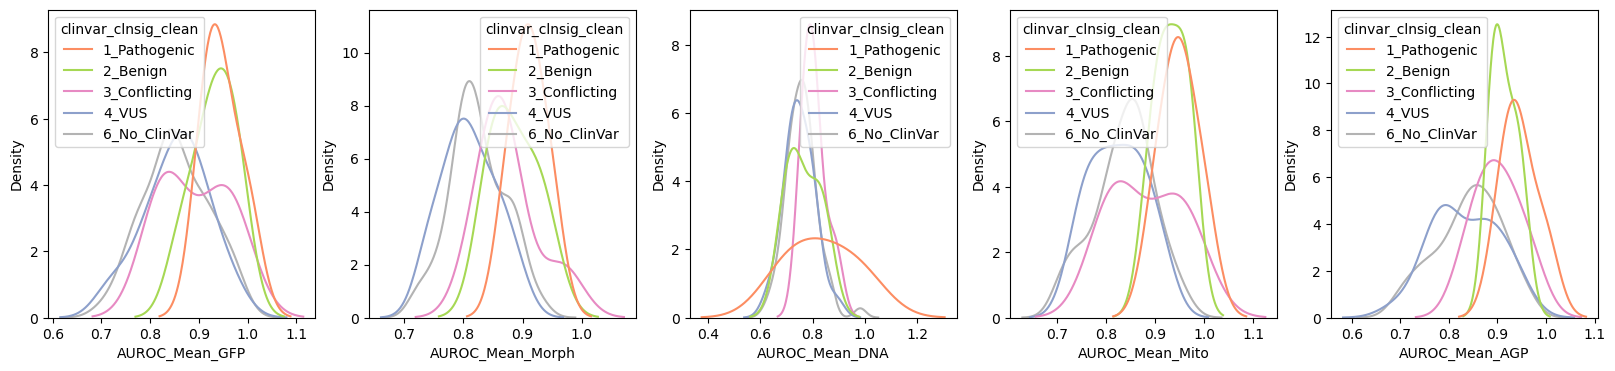

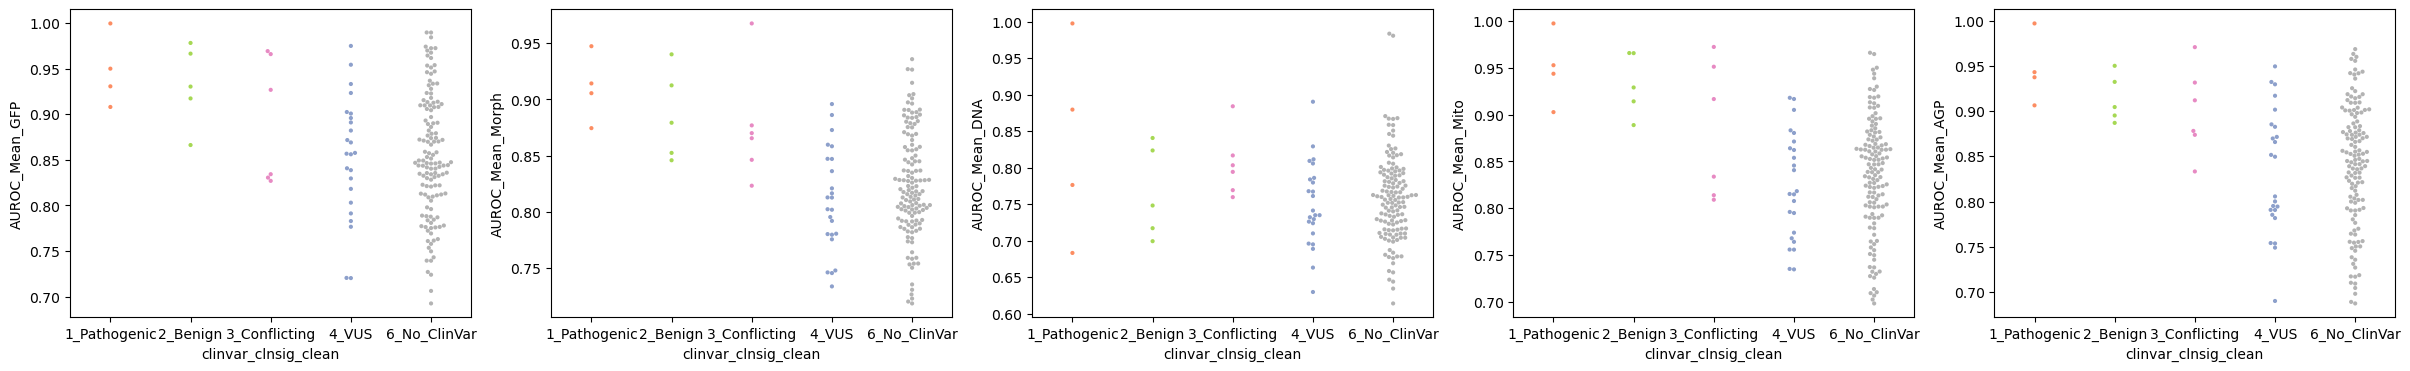

In [23]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
for feat in FEAT_SETS:
    sns.kdeplot(
        data=imaging_summary_clinvar.filter(pl.col("clinvar_clnsig_clean")!="5_Others").to_pandas(),
        x=f"AUROC_Mean_{feat}",
        common_norm=False,
        ax=axes[FEAT_SETS.index(feat)],
        hue="clinvar_clnsig_clean",
        palette=palette_dict["clinvar_clnsig_clean"],
        # col="clinvar_clnsig_clean_dbnsfp",
        # col_order=sorted(summary_clin_var.filter(pl.col("clinvar_clnsig_clean_dbnsfp")!="5_Others")["clinvar_clnsig_clean_dbnsfp"].drop_nulls().unique()),
        hue_order=sorted(imaging_summary_clinvar.filter(pl.col("clinvar_clnsig_clean")!="5_Others")["clinvar_clnsig_clean"].drop_nulls().unique())
    )

fig, axes = plt.subplots(1, 5, figsize=(30,4))
for feat in FEAT_SETS:
    sns.swarmplot(data=imaging_summary_clinvar.to_pandas(),
                  x="clinvar_clnsig_clean", y=f"AUROC_Mean_{feat}",
                  hue="clinvar_clnsig_clean",
                  ax=axes[FEAT_SETS.index(feat)],
                  palette=palette_dict["clinvar_clnsig_clean"],
                  size=3,
                  order=sorted(imaging_summary_clinvar["clinvar_clnsig_clean"].unique()))
# axes[FEAT_SETS.index(feat)].set_xticklabels(axes[FEAT_SETS.index(feat)].get_xticklabels(), rotation=45)
plt.subplots_adjust(wspace=0.2)

In [25]:
with pl.Config(set_tbl_rows=30):
    display(
        imaging_summary_clinvar.filter(
            pl.any_horizontal([pl.col(f"Altered_95th_perc_{col}") for col in ["DNA","GFP","AGP","Mito","Morph"]])
        ).sort([pl.col(f"AUROC_Mean_{col}") for col in ["GFP","DNA","AGP","Mito","Morph"]], descending=True).select(
            ["gene_allele","Metadata_Bio_Batch","clinvar_clnsig_clean"]+[pl.col(f"Altered_95th_perc_{col}") for col in ["GFP","DNA","AGP","Mito","Morph"]]+[pl.col(f"AUROC_Mean_{col}") for col in ["GFP","DNA","AGP","Mito","Morph"]]
        )
    )

shape: (30, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ gene_alle ┆ Metadata_ ┆ clinvar_c ┆ Altered_9 ┆ … ┆ AUROC_Mea ┆ AUROC_Mea ┆ AUROC_Mea ┆ AUROC_Me │
│ le        ┆ Bio_Batch ┆ lnsig_cle ┆ 5th_perc_ ┆   ┆ n_DNA     ┆ n_AGP     ┆ n_Mito    ┆ an_Morph │
│ ---       ┆ ---       ┆ an        ┆ GFP       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│           ┆           ┆ str       ┆ f64       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ CCM2_Met1 ┆ 2025_06_B ┆ 1_Pathoge ┆ 1.0       ┆ … ┆ 0.99767   ┆ 0.996871  ┆ 0.99735   ┆ 0.905545 │
│ Val       ┆ atch_18-1 ┆ nic       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 9         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ile4 ┆ 2025_01_B ┆ 6_No_Clin ┆ 1.0       ┆ … ┆ 0.980848  ┆ 0.955554  ┆ 0.964669  ┆ 0.836921 │
│ 25Thr     ┆ atch_13-1 ┆ Var       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ile4 ┆ 2025_01_B ┆ 6_No_Clin ┆ 1.0       ┆ … ┆ 0.983663  ┆ 0.959972  ┆ 0.950093  ┆ 0.807628 │
│ 32Thr     ┆ atch_13-1 ┆ Var       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ile3 ┆ 2025_01_B ┆ 6_No_Clin ┆ 1.0       ┆ … ┆ 0.826384  ┆ 0.968527  ┆ 0.96608   ┆ 0.904743 │
│ 72Leu     ┆ atch_13-1 ┆ Var       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Phe2 ┆ 2025_06_B ┆ 2_Benign  ┆ 1.0       ┆ … ┆ 0.840679  ┆ 0.950078  ┆ 0.965632  ┆ 0.940069 │
│ 70Leu     ┆ atch_18-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 9         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Arg4 ┆ 2025_01_B ┆ 4_VUS     ┆ 1.0       ┆ … ┆ 0.890375  ┆ 0.949446  ┆ 0.917973  ┆ 0.780717 │
│ 23Pro     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Gly3 ┆ 2025_01_B ┆ 6_No_Clin ┆ 1.0       ┆ … ┆ 0.762542  ┆ 0.943594  ┆ 0.943718  ┆ 0.869106 │
│ 79Ser     ┆ atch_13-1 ┆ Var       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Asp3 ┆ 2025_01_B ┆ 6_No_Clin ┆ 1.0       ┆ … ┆ 0.716465  ┆ 0.91574   ┆ 0.91807   ┆ 0.785153 │
│ 01Gly     ┆ atch_13-1 ┆ Var       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Arg1 ┆ 2025_01_B ┆ 6_No_Clin ┆ 1.0       ┆ … ┆ 0.796153  ┆ 0.914288  ┆ 0.919449  ┆ 0.823117 │
│ 9Gln      ┆ atch_13-1 ┆ Var       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Asp3 ┆ 2025_01_B ┆ 6_No_Clin ┆ 1.0       ┆ … ┆ 0.771077  ┆ 0.93597   ┆ 0.9299    ┆ 0.850122 │
│ 76His     ┆ atch_13-1 ┆ Var       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Val1 ┆ 2025_01_B ┆ 3_Conflic ┆ 1.0       ┆ … ┆ 0.816756  ┆ 0.93155   ┆ 0.951155  ┆ 0.876945 │
│ 90Met     ┆ atch_13-1 ┆ ting      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆        

In [26]:
ccm2_allele_hits = imaging_summary_clinvar.filter(
    pl.any_horizontal([pl.col(f"Altered_95th_perc_{col}") for col in FEAT_SETS])
).sort([pl.col(f"AUROC_Mean_{col}") for col in FEAT_SETS], descending=True).select(
    ["gene_allele"]+[pl.col(f"Altered_95th_perc_{col}") for col in FEAT_SETS]+[pl.col(f"AUROC_Mean_{col}") for col in FEAT_SETS]
)

long_df = pl.concat([
    ccm2_allele_hits.select([
        pl.col("gene_allele"),
        pl.lit(cat).alias("Channel"),
        pl.col(f"Altered_95th_perc_{cat}")
            .cast(pl.Boolean)           # 1.0 → True , 0.0 → False
            .alias("Altered_95th_perc"),
        pl.col(f"AUROC_Mean_{cat}")
            .alias("AUROC_Mean")
    ])
    for cat in FEAT_SETS
]).rename({"gene_allele": "CCM2_Variant"})
long_df

shape: (150, 4)
┌────────────────┬─────────┬───────────────────┬────────────┐
│ CCM2_Variant   ┆ Channel ┆ Altered_95th_perc ┆ AUROC_Mean │
│ ---            ┆ ---     ┆ ---               ┆ ---        │
│ str            ┆ str     ┆ bool              ┆ f64        │
╞════════════════╪═════════╪═══════════════════╪════════════╡
│ CCM2_Met1Val   ┆ GFP     ┆ true              ┆ 0.99955    │
│ CCM2_Ile425Thr ┆ GFP     ┆ true              ┆ 0.989657   │
│ CCM2_Ile432Thr ┆ GFP     ┆ true              ┆ 0.9896     │
│ CCM2_Ile372Leu ┆ GFP     ┆ true              ┆ 0.984296   │
│ CCM2_Phe270Leu ┆ GFP     ┆ true              ┆ 0.978169   │
│ …              ┆ …       ┆ …                 ┆ …          │
│ CCM2_Tyr261Asp ┆ AGP     ┆ false             ┆ 0.904046   │
│ CCM2_Thr241Ile ┆ AGP     ┆ false             ┆ 0.941824   │
│ CCM2_Arg40Cys  ┆ AGP     ┆ false             ┆ 0.856171   │
│ CCM2_Pro240Leu ┆ AGP     ┆ false             ┆ 0.844554   │
│ CCM2_Pro102Leu ┆ AGP     ┆ false             ┆ 0.856702   │
└────────────────┴─────────┴───────────────────┴────────────┘

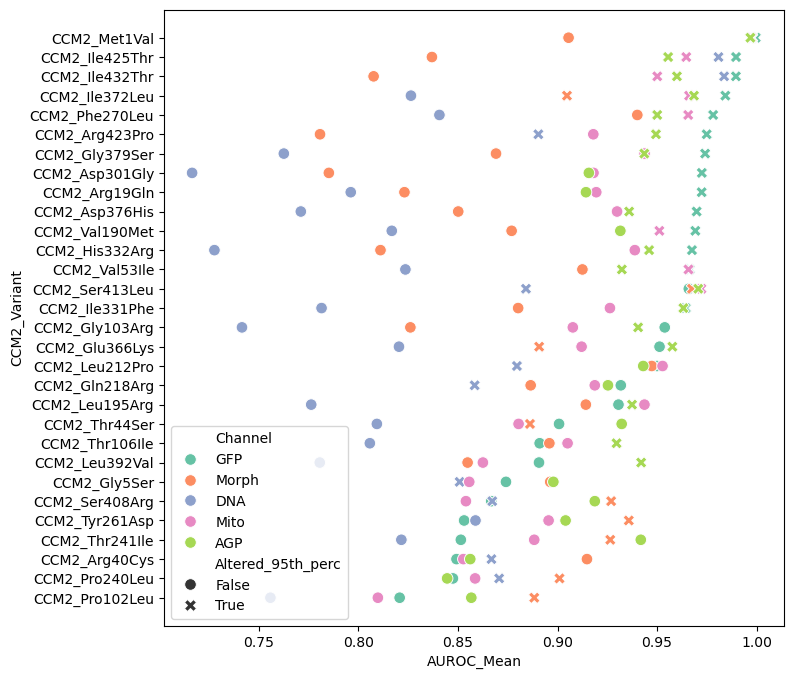

In [27]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.scatterplot(data=long_df.to_pandas(), y="CCM2_Variant", x="AUROC_Mean", 
                style="Altered_95th_perc", hue="Channel", ax=ax, s=70, palette="Set2")
ax.legend(ncol=1, frameon=True)

In [28]:
allele_meta_df = pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
            # display(allele_meta_df.head())
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    # print(f"{IMG_QC_DIR.format(bio_rep=bio_rep)}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR.format(bio_rep=bio_rep)}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum = img_well_qc_sum.with_columns(
        pl.col("channel").replace("DAPI", "DNA").alias("channel")
    )
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio")
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

## 2. Loading CellProfiler Features

### Define functions

In [29]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from collections import defaultdict
from matplotlib import colormaps
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

In [30]:
def remove_corr_feats(df, feat_cols=None, corr_thres=.9):
    if feat_cols is None:
        # 2. Identify numeric columns
        all_num_feats = [
            name
            for name, dtype in df.schema.items()
            if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64)
        ]
    else:
        all_num_feats = feat_cols
        
    # 3. Bring that slice into pandas
    pdf = df.select(all_num_feats).to_pandas()
    # 4. Compute absolute correlation matrix
    corr = pdf.corr().abs()
    # 5. Mask out the lower triangle (we only need one side)
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )
    # 6. Pick columns to drop: any column with correlation > threshold to *any* other
    to_drop = [col for col in upper.columns if any(upper[col] > corr_thres)]
    # 7. Drop them in your original Polars DF
    df_drop_corr_cols = df.drop(to_drop)
    # colocal_col_cat = set(["_".join(col.split('_')[1:3]) for col in colocal_cols])
    # print(colocal_col_cat)
    # colocal_col_dict = defaultdict(list)
    # for col in colocal_cols:
    #     colocal_col_dict["_".join(col.split('_')[1:3])].append(col)
    # colocal_col_dict
    return df_drop_corr_cols


def inverse_normal_transform(data, feat_cols=None):
    """
    Apply inverse normal transformation (rank-based normalization) to data.
    """
    from scipy.stats import norm
    from scipy.stats import rankdata
    
    def transform_column_polars(col_name, df):
        """Transform a polars column"""
        return (
            pl.when(pl.col(col_name).is_not_null())
            .then(
                pl.col(col_name)
                .rank(method="average")
                .sub(0.5)
                .truediv(pl.col(col_name).drop_nulls().len())
                .map_elements(lambda x: norm.ppf(x), return_dtype=pl.Float64)
            )
            .otherwise(pl.col(col_name))
            .alias(col_name)
        )

    if feat_cols is None:
        numeric_cols = [
            col 
            for col in data.columns 
            if data[col].dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64]
        ]
    else:
        numeric_cols = feat_cols
        
    # Polars DataFrame
    
    # Apply transformation to numeric columns only
    transformations = [transform_column_polars(col, data) for col in numeric_cols]
    non_numeric_cols = [col for col in data.columns if col not in numeric_cols]
    
    if transformations:
        if non_numeric_cols:
            # Keep non-numeric columns as they are
            return data.with_columns(transformations).select(data.columns)
        else:
            return data.with_columns(transformations)
    else:
        return data  # No numeric columns to transform

In [31]:
def gap_statistic(data, distance_vector, linkage_matrix, k_range, n_refs=10, random_state=42):
    """
    Calculate Gap statistic for optimal cluster number selection.
    
    Parameters:
    -----------
    data : array-like
        Original data matrix
    distance_vector : array-like
        Precomputed distance vector from pdist
    linkage_matrix : array-like
        Hierarchical clustering linkage matrix
    k_range : range
        Range of k values to test
    n_refs : int
        Number of reference datasets to generate
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    tuple : (gap_values, gap_std, optimal_k)
    """
    np.random.seed(random_state)
    
    # Calculate within-cluster sum of squares for original data
    def calculate_wss(labels, distance_matrix):
        wss = 0
        for cluster_id in np.unique(labels):
            cluster_indices = np.where(labels == cluster_id)[0]
            if len(cluster_indices) > 1:
                cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
                wss += np.sum(cluster_distances) / (2 * len(cluster_indices))
        return wss
    
    distance_matrix = squareform(distance_vector)
    original_wss = []
    
    # Calculate WSS for original data
    for k in k_range:
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        wss = calculate_wss(labels, distance_matrix)
        original_wss.append(wss)
    
    # Generate reference datasets and calculate WSS
    reference_wss = []
    for _ in range(n_refs):
        # Generate reference data by sampling from uniform distribution
        # matching the range of original data
        ref_data = np.random.uniform(
            low=data.min(axis=0), 
            high=data.max(axis=0), 
            size=data.shape
        )
        
        # Compute distances and linkage for reference data
        from scipy.spatial.distance import pdist
        from scipy.cluster.hierarchy import linkage
        ref_dist = pdist(ref_data, metric='cosine')
        ref_linkage = linkage(ref_dist, method='average')
        ref_distance_matrix = squareform(ref_dist)
        
        ref_wss_k = []
        for k in k_range:
            ref_labels = fcluster(ref_linkage, k, criterion='maxclust')
            ref_wss = calculate_wss(ref_labels, ref_distance_matrix)
            ref_wss_k.append(ref_wss)
        reference_wss.append(ref_wss_k)
    
    # Calculate gap statistic
    reference_wss = np.array(reference_wss)
    gap_values = np.log(np.mean(reference_wss, axis=0)) - np.log(original_wss)
    gap_std = np.sqrt(np.var(np.log(reference_wss), axis=0) * (1 + 1/n_refs))
    
    # Find optimal k using gap statistic
    # Choose smallest k such that Gap(k) >= Gap(k+1) - s_(k+1)
    optimal_k = k_range[0]
    for i, k in enumerate(k_range[:-1]):
        if gap_values[i] >= gap_values[i+1] - gap_std[i+1]:
            optimal_k = k
            break
    
    return gap_values, gap_std, optimal_k


def elbow_method(wss_values, k_range, sensitivity=1.0):
    """
    Find elbow point using the rate of change method.
    
    Parameters:
    -----------
    wss_values : list
        Within-cluster sum of squares values
    k_range : range
        Range of k values
    sensitivity : float
        Sensitivity parameter for elbow detection
    
    Returns:
    --------
    int : optimal k value
    """
    if len(wss_values) < 3:
        return k_range[0]
    
    # Calculate rate of change (first derivative)
    rate_of_change = np.diff(wss_values)
    
    # Calculate acceleration (second derivative)
    acceleration = np.diff(rate_of_change)
    
    # Find point where acceleration is maximum (most negative)
    # This indicates the sharpest bend in the curve
    elbow_idx = np.argmax(acceleration) + 1  # +1 because of double diff
    
    # Apply sensitivity adjustment
    if sensitivity != 1.0:
        # Adjust based on the magnitude of change
        threshold = np.max(np.abs(acceleration)) * sensitivity
        valid_indices = np.where(np.abs(acceleration) >= threshold)[0]
        if len(valid_indices) > 0:
            elbow_idx = valid_indices[0] + 1
    
    return k_range[min(elbow_idx, len(k_range) - 1)]


def find_optimal_clusters_robust(data, distance_vector, linkage_matrix, 
                                min_k=2, max_k=20, methods='all', 
                                plot_metrics=True, random_state=42):
    """
    Find optimal number of clusters using multiple robust criteria.
    
    Parameters:
    -----------
    data : pandas.DataFrame or numpy.array
        Original data matrix
    distance_vector : array-like
        Precomputed distance vector from pdist
    linkage_matrix : array-like
        Hierarchical clustering linkage matrix
    min_k : int
        Minimum number of clusters to consider
    max_k : int
        Maximum number of clusters to consider
    methods : str or list
        Methods to use: 'all', 'fast', or list of method names
        Available: ['silhouette', 'calinski_harabasz', 'davies_bouldin', 
                   'gap_statistic', 'elbow', 'stability']
    plot_metrics : bool
        Whether to plot the metrics
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict : Results containing optimal k values and all metrics
    """
    np.random.seed(random_state)
    
    # Ensure we don't exceed data size
    max_k = min(max_k, len(data) - 1)
    k_range = range(min_k, max_k + 1)
    
    # Define available methods
    available_methods = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 
                        'gap_statistic', 'elbow', 'stability']
    
    # Determine which methods to use
    if methods == 'all':
        use_methods = available_methods
    elif methods == 'fast':
        use_methods = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'elbow']
    elif isinstance(methods, list):
        use_methods = [m for m in methods if m in available_methods]
    else:
        use_methods = ['silhouette', 'calinski_harabasz']
    
    # Initialize results
    scores = defaultdict(list)
    optimal_ks = {}
    distance_matrix = squareform(distance_vector)
    
    # Calculate metrics for each k
    wss_values = []  # For elbow method
    stability_scores = []  # For stability analysis
    
    for k in k_range:
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        
        # Skip if we get only one cluster or all singletons
        if len(np.unique(labels)) < 2 or len(np.unique(labels)) >= len(data):
            scores['silhouette'].append(-1)
            scores['calinski_harabasz'].append(0)
            scores['davies_bouldin'].append(np.inf)
            wss_values.append(np.inf)
            stability_scores.append(0)
            continue
        
        # Silhouette Score
        if 'silhouette' in use_methods:
            try:
                sil_score = silhouette_score(distance_matrix, labels, metric='precomputed')
                scores['silhouette'].append(sil_score)
            except:
                scores['silhouette'].append(-1)
        
        # Calinski-Harabasz Score
        if 'calinski_harabasz' in use_methods:
            try:
                ch_score = calinski_harabasz_score(data, labels)
                scores['calinski_harabasz'].append(ch_score)
            except:
                scores['calinski_harabasz'].append(0)
        
        # Davies-Bouldin Score (lower is better)
        if 'davies_bouldin' in use_methods:
            try:
                db_score = davies_bouldin_score(data, labels)
                scores['davies_bouldin'].append(db_score)
            except:
                scores['davies_bouldin'].append(np.inf)
        
        # Within-cluster sum of squares for elbow method
        if 'elbow' in use_methods:
            wss = 0
            for cluster_id in np.unique(labels):
                cluster_indices = np.where(labels == cluster_id)[0]
                if len(cluster_indices) > 1:
                    cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
                    wss += np.sum(cluster_distances) / (2 * len(cluster_indices))
            wss_values.append(wss)
        
        # Stability analysis
        if 'stability' in use_methods:
            # Bootstrap sampling to assess cluster stability
            n_bootstrap = 10
            stability_scores_k = []
            
            for _ in range(n_bootstrap):
                # Sample with replacement
                boot_indices = np.random.choice(len(data), size=len(data), replace=True)
                boot_data = data.iloc[boot_indices] if hasattr(data, 'iloc') else data[boot_indices]
                
                try:
                    from scipy.spatial.distance import pdist
                    from scipy.cluster.hierarchy import linkage
                    boot_dist = pdist(boot_data, metric='cosine')
                    boot_linkage = linkage(boot_dist, method='average')
                    boot_labels = fcluster(boot_linkage, k, criterion='maxclust')
                    
                    # Calculate adjusted rand index with original clustering
                    from sklearn.metrics import adjusted_rand_score
                    original_labels_boot = labels[boot_indices]
                    ari = adjusted_rand_score(original_labels_boot, boot_labels)
                    stability_scores_k.append(max(0, ari))  # Ensure non-negative
                except:
                    stability_scores_k.append(0)
            
            stability_scores.append(np.mean(stability_scores_k))
    
    # Find optimal k for each method
    
    # Silhouette: maximize
    if 'silhouette' in use_methods and scores['silhouette']:
        valid_scores = [(i, s) for i, s in enumerate(scores['silhouette']) if s > -1]
        if valid_scores:
            best_idx = max(valid_scores, key=lambda x: x[1])[0]
            optimal_ks['silhouette'] = k_range[best_idx]
    
    # Calinski-Harabasz: maximize
    if 'calinski_harabasz' in use_methods and scores['calinski_harabasz']:
        valid_scores = [(i, s) for i, s in enumerate(scores['calinski_harabasz']) if s > 0]
        if valid_scores:
            best_idx = max(valid_scores, key=lambda x: x[1])[0]
            optimal_ks['calinski_harabasz'] = k_range[best_idx]
    
    # Davies-Bouldin: minimize
    if 'davies_bouldin' in use_methods and scores['davies_bouldin']:
        valid_scores = [(i, s) for i, s in enumerate(scores['davies_bouldin']) if s < np.inf]
        if valid_scores:
            best_idx = min(valid_scores, key=lambda x: x[1])[0]
            optimal_ks['davies_bouldin'] = k_range[best_idx]
    
    # Elbow method
    if 'elbow' in use_methods and len(wss_values) > 2:
        optimal_ks['elbow'] = elbow_method(wss_values, k_range)
    
    # Gap statistic
    if 'gap_statistic' in use_methods:
        try:
            gap_values, gap_std, gap_optimal_k = gap_statistic(
                data, distance_vector, linkage_matrix, k_range, 
                n_refs=10, random_state=random_state
            )
            scores['gap_statistic'] = gap_values
            scores['gap_std'] = gap_std
            optimal_ks['gap_statistic'] = gap_optimal_k
        except Exception as e:
            print(f"Gap statistic calculation failed: {e}")
    
    # Stability analysis
    if 'stability' in use_methods and stability_scores:
        best_idx = np.argmax(stability_scores)
        optimal_ks['stability'] = k_range[best_idx]
        scores['stability'] = stability_scores
    
    # Consensus optimal k (majority vote)
    if optimal_ks:
        from collections import Counter
        k_votes = Counter(optimal_ks.values())
        consensus_k = k_votes.most_common(1)[0][0]
        
        # If there's a tie, prefer methods in order of reliability
        method_priority = ['gap_statistic', 'silhouette', 'stability', 
                          'calinski_harabasz', 'davies_bouldin', 'elbow']
        if len([k for k, count in k_votes.items() if count == k_votes.most_common(1)[0][1]]) > 1:
            for method in method_priority:
                if method in optimal_ks:
                    consensus_k = optimal_ks[method]
                    break
    else:
        consensus_k = min_k
    
    # Plot metrics if requested
    if plot_metrics and scores:
        plot_clustering_metrics(k_range, scores, optimal_ks, consensus_k)
    
    # Prepare results
    results = {
        'optimal_k': consensus_k,
        'optimal_ks_by_method': optimal_ks,
        'scores': dict(scores),
        'k_range': list(k_range),
        'methods_used': use_methods,
        'consensus_votes': dict(k_votes) if optimal_ks else {},
    }
    
    return results


def plot_clustering_metrics(k_range, scores, optimal_ks, consensus_k):
    """Plot clustering validation metrics."""
    
    # Count non-empty scores - handle both lists and arrays
    non_empty_scores = {}
    for k, v in scores.items():
        if k != 'gap_std':  # Skip gap standard deviation
            if isinstance(v, (list, np.ndarray)) and len(v) > 0:
                # Check if it's not all zeros/invalid values
                if isinstance(v, np.ndarray):
                    if not np.all(np.isinf(v)) and not np.all(np.isnan(v)) and np.any(v != 0):
                        non_empty_scores[k] = v
                else:  # list
                    if not all(x == 0 or x == -1 or np.isinf(x) for x in v):
                        non_empty_scores[k] = v
    
    n_metrics = len(non_empty_scores)
    
    if n_metrics == 0:
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Plot each metric
    for metric_name, values in non_empty_scores.items():
        if plot_idx >= 6:  # Max 6 subplots
            break
            
        ax = axes[plot_idx]
        
        # Plot the metric
        ax.plot(k_range, values, 'bo-', linewidth=2, markersize=6)
        
        # Highlight optimal k for this method
        if metric_name in optimal_ks:
            optimal_k = optimal_ks[metric_name]
            optimal_idx = list(k_range).index(optimal_k)
            ax.plot(optimal_k, values[optimal_idx], 'ro', markersize=10, 
                   label=f'Optimal k={optimal_k}')
        
        # Highlight consensus k
        if consensus_k in k_range:
            consensus_idx = list(k_range).index(consensus_k)
            ax.axvline(x=consensus_k, color='green', linestyle='--', alpha=0.7,
                      label=f'Consensus k={consensus_k}')
        
        ax.set_xlabel('Number of Clusters (k)')
        ax.set_ylabel(metric_name.replace('_', ' ').title())
        ax.set_title(f'{metric_name.replace("_", " ").title()} Score')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, 6):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Clustering Validation Metrics', y=1.02, fontsize=16, weight='bold')
    plt.show()


# Updated main clustering function
def robust_cosine_clustering_with_annotations(df, 
                                              feature_cols,
                                              annotation_cols,
                                              continuous_annotations,
                                              n_clusters=None, 
                                              method='average', 
                                              min_clusters=2, 
                                              max_clusters=20,
                                              optimal_ordering=True,
                                              clustering_methods='fast',
                                              plot_validation=True):
    """
    Enhanced clustering function with robust optimal cluster selection.
    
    Additional Parameters:
    ---------------------
    clustering_methods : str or list
        Methods for optimal cluster selection: 'all', 'fast', or list of methods
    plot_validation : bool
        Whether to plot validation metrics
    """
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.cluster import AgglomerativeClustering
    from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
    from scipy.spatial.distance import squareform, pdist
    
    # Extract feature data for clustering
    data = df[feature_cols].astype(float)
    
    # Compute cosine distance between samples
    cosine_dist = pdist(data, metric='cosine')
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(cosine_dist, method=method)
    
    # Optimal leaf ordering to minimize distance jumps
    if optimal_ordering:
        opt_linkage = optimal_leaf_ordering(linkage_matrix, cosine_dist)
    else:
        opt_linkage = linkage_matrix
    
    # Determine optimal number of clusters if not specified
    if n_clusters is None:
        print("Finding optimal number of clusters...")
        cluster_results = find_optimal_clusters_robust(
            data, cosine_dist, linkage_matrix, 
            min_k=min_clusters, max_k=max_clusters,
            methods=clustering_methods,
            plot_metrics=plot_validation
        )
        n_clusters = cluster_results['optimal_k']
        
        print(f"Optimal cluster selection results:")
        print(f"Consensus optimal k: {n_clusters}")
        print(f"Method-specific optimal k values: {cluster_results['optimal_ks_by_method']}")
        print(f"Consensus votes: {cluster_results['consensus_votes']}")
    
    # Get cluster labels
    cluster_labels = fcluster(opt_linkage, n_clusters, criterion='maxclust')
    
    # Create cluster labels for samples
    sample_cluster_df = pd.DataFrame({
        'Sample': data.index,
        'Cluster': cluster_labels
    }).set_index('Sample')
    
    # Create results dictionary
    results = {
        'data': df[feature_cols],
        'cluster_labels': cluster_labels,
        'n_clusters': n_clusters,
        'linkage_matrix': opt_linkage,
        'linkage_method': method,
        'feature_cols': feature_cols,
        'annotation_cols': annotation_cols,
        'continuous_annotations': continuous_annotations,
        'sample_clusters': sample_cluster_df,
    }
    
    # Add validation results if computed
    if n_clusters and 'cluster_results' in locals():
        results['validation_results'] = cluster_results
    return results

In [32]:
def find_optimal_clusters_pdist(data, distance_vector, linkage_matrix, min_k, max_k):
    """Find optimal number of clusters using multiple criteria with precomputed distances."""
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    scores = {
        'silhouette': [],
        'calinski_harabasz': []
    }
    k_range = range(min_k, min(max_k + 1, len(data)))
    for k in k_range:
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        try:
            # Silhouette score using precomputed distances
            distance_matrix = squareform(distance_vector)
            sil_score = silhouette_score(distance_matrix, labels, metric='precomputed')
            scores['silhouette'].append(sil_score)
            
            # Calinski-Harabasz score (higher is better)
            ch_score = calinski_harabasz_score(data, labels)
            scores['calinski_harabasz'].append(ch_score)
        except:
            scores['silhouette'].append(-1)
            scores['calinski_harabasz'].append(0)
    
    # Find optimal k based on silhouette score
    if scores['silhouette'] and max(scores['silhouette']) > -1:
        optimal_k = k_range[np.argmax(scores['silhouette'])]
    else:
        optimal_k = min_k
    return optimal_k
    

def robust_cosine_clustering_with_annotations(df, 
                                              feature_cols,
                                              annotation_cols,
                                              continuous_annotations,
                                              n_clusters=None, 
                                              method='average', 
                                              min_clusters=2, 
                                              max_clusters=20,
                                              optimal_ordering=True,
                                              clustering_methods='fast',
                                              plot_validation=True):
    """
    Perform robust clustering using cosine similarities with categorical and continuous annotations.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Feature matrix with annotations (features/annotations x samples)
    feature_cols : list, optional
        List of col names to use for clustering. If None, will exclude annotation rows
    annotation_cols : list, optional
        List of categorical annotation col names (e.g., ["clinvar_clnsig_clean", "Altered_95th_perc_GFP"])
    continuous_annotations : list, optional
        List of continuous annotation row names (e.g., ["AUROC"])
    n_clusters : int, optional
        Number of clusters. If None, will be determined automatically
    method : str
        Linkage method for hierarchical clustering
    standardize : bool
        Whether to standardize features before clustering
    optimal_ordering : bool
        Whether to use optimal leaf ordering
    
    Returns:
    --------
    dict with clustering results and validation metrics
    """
    # Extract feature data for clustering
    data = df[feature_cols].astype(float)
    
    # Step 2: Compute cosine distance between columns (samples)
    # Transpose to cluster columns (samples) -> shape (n_samples, n_features)    
    # Compute cosine distance between samples
    cosine_dist = pdist(data, metric='cosine')
    
    # Step 3: Perform hierarchical clustering
    linkage_matrix = linkage(cosine_dist, method=method)
    
    # Step 4: Optimal leaf ordering to minimize distance jumps
    if optimal_ordering:
        opt_linkage = optimal_leaf_ordering(linkage_matrix, cosine_dist)
    else:
        opt_linkage = linkage_matrix
    
    # Step 5: Determine optimal number of clusters if not specified
    if n_clusters is None:
        # n_clusters = find_optimal_clusters_pdist(
        #     data, cosine_dist, linkage_matrix, 
        #     min_clusters, max_clusters
        # )
        
        cluster_results = find_optimal_clusters_robust(
            data, cosine_dist, linkage_matrix, 
            min_k=min_clusters, max_k=max_clusters,
            methods=clustering_methods,
            plot_metrics=plot_validation
        )
        n_clusters = cluster_results['optimal_k']
        
        print(f"Optimal cluster selection results:")
        print(f"Consensus optimal k: {n_clusters}")
        print(f"Method-specific optimal k values: {cluster_results['optimal_ks_by_method']}")
        print(f"Consensus votes: {cluster_results['consensus_votes']}")
    
    # Step 6: Get cluster labels
    cluster_labels = fcluster(opt_linkage, n_clusters, criterion='maxclust')
    
    # Create cluster labels for samples
    sample_cluster_df = pd.DataFrame({
        'Sample': data.index,
        'Cluster': cluster_labels
    }).set_index('Sample')
    
    # Step 7: Create results dictionary
    results = {
        'data': df[feature_cols],
        'cosine_dist': cosine_dist,
        'cluster_labels': cluster_labels,
        'n_clusters': n_clusters,
        'linkage_matrix': opt_linkage,
        'linkage_method': method,
        'feature_cols': feature_cols,
        'annotation_cols': annotation_cols,
        'continuous_annotations': continuous_annotations,
        'sample_clusters': sample_cluster_df,
    }
    return results


def create_column_colors_dataframe(df, clustering_results, palettes):
    """Create a DataFrame with column colors for all annotations and clusters."""
    annotation_cols = clustering_results['annotation_cols']
    continuous_annotations = clustering_results['continuous_annotations']
    sample_clusters = clustering_results['sample_clusters']
    
    col_colors_dict = {}
    palette_map = 2 * [sns.color_palette("husl"), sns.color_palette("hls"), sns.color_palette("tab10"), sns.color_palette("muted"), sns.color_palette("colorblind")]
    # Add categorical annotations
    for i, ann_col in enumerate(annotation_cols):
        if ann_col in df.columns:
            if ann_col in palettes:
                col_colors_dict[ann_col] = df[ann_col].map(palettes[ann_col])
            else:
                ann_elements = df[ann_col].unique()
                palettes[ann_col] = dict(zip(ann_elements, palette_map[i][:len(ann_elements)]))
                col_colors_dict[ann_col] = df[ann_col].map(palettes[ann_col])
                
    # Add cluster colors
    cluster_series = pd.Series(clustering_results['cluster_labels'], 
                               index=df.index)
    cluster_set = sorted(set(clustering_results['cluster_labels']))
    # display(cluster_series.sort_values())
    palettes['Cluster'] = dict(zip(cluster_set, sns.color_palette("husl", len(cluster_set))))
    col_colors_dict['Cluster'] = cluster_series.map(palettes['Cluster'])
    
    # Add continuous annotations (normalized to [0,1] for colormap)
    for cont_ann in continuous_annotations:
        if cont_ann in df.columns:
            values = df[cont_ann].astype(float)
            # Normalize values to [0,1]
            normalized_values = (values - values.min()) / (values.max() - values.min())
            # Apply colormap
            cmap = colormaps.get_cmap("viridis_r") #plt.cm.get_cmap("")
            col_colors_dict[cont_ann] = [cmap(val) for val in normalized_values]
    
    # Create DataFrame
    col_colors_df = pd.DataFrame(col_colors_dict, index=df.index)
    return col_colors_df, palettes
    

def create_comprehensive_clustermap(df, clustering_results, title_label,
                                    cmap='vlag', 
                                    save_path=None, show_legends=True):
    """
    Create a comprehensive clustermap with all annotations and cluster information.
    """
    
    # Get the clustering data
    data = clustering_results['data']
    linkage_matrix = clustering_results['linkage_matrix']

    clinvar_palette_set2 = sns.color_palette("Set2")
    clinvar_palette_set2[0], clinvar_palette_set2[1], clinvar_palette_set2[2], clinvar_palette_set2[3], clinvar_palette_set2[4], clinvar_palette_set2[5], clinvar_palette_set2[7] = \
    clinvar_palette_set2[1], clinvar_palette_set2[4], clinvar_palette_set2[3], clinvar_palette_set2[2], clinvar_palette_set2[0], clinvar_palette_set2[7], clinvar_palette_set2[5]
    clinvar_category = ['1_Pathogenic', '2_Benign', '3_Conflicting', '4_VUS', '5_Others', '6_No_ClinVar']
    palettes = {
        "clinvar_clnsig_clean": dict(zip(clinvar_category, clinvar_palette_set2[:7]))
    }

    # Create column colors DataFrame
    col_colors_df, palettes = create_column_colors_dataframe(
        df, clustering_results, palettes
    )

    figsize = (data.shape[1] / 1.2, data.shape[1] // 2)
    ## Create the clustermap
    g = sns.clustermap(
        data.T,
        col_linkage=linkage_matrix,
        col_colors=col_colors_df,
        cmap=cmap,
        cbar_pos=(-.05, .3, .02, .25),
        cbar_kws={'label': "Normalized CP Feature"},
        figsize=figsize,
        linewidths=0.01,
        row_cluster=True,  # Also cluster features
        xticklabels=True,  # Hide sample labels for cleaner look
        yticklabels=True
    )
    
    # Customize the plot
    g.ax_heatmap.set_xlabel('Samples (Clustered)', fontsize=12)
    g.ax_heatmap.set_ylabel('Features', fontsize=12)
    # g.ax_cbar.tick_params(axis='x', length=10)
    
    # Add legends if requested
    if show_legends:
        # Calculate number of columns for horizontal legend layout
        n_legends = len([name for name in palettes.keys() 
                        if name in clustering_results['annotation_cols'] or name == 'Cluster'])
        n_cols = 5  # Max 3 columns
        
        # Position legends horizontally below the plot
        legend_y = .95
        legend_x_start = 0.75
        legend_x_spacing = 0.15
        for i, (ann_name, palette) in enumerate(palettes.items()):
            if ann_name in clustering_results['annotation_cols'] or ann_name == 'Cluster':
                handles = [mpatches.Patch(color=color, label=l) 
                          for l, color in palette.items()]
                col = i % n_cols
                row = i // n_cols
                legend = g.fig.legend(handles=handles, title=ann_name,
                                      bbox_to_anchor=(legend_x_start - col * legend_x_spacing, legend_y - row * 0.1),
                                      loc='upper right',
                                      ncol=1,
                                      frameon=True)
                legend.set_title(ann_name, prop={'weight': 'bold', 'size': 10})
        
        # # Add continuous annotation info
        # cont_info = []
        # for cont_ann in clustering_results['continuous_annotations']:
        #     if cont_ann in df.columns:
        #         values = df[cont_ann].astype(float)
        #         cont_info.append(f"{cont_ann}: {values.min():.2f}-{values.max():.2f}")
        
        # if cont_info:
        #     g.fig.text(0.1, legend_y - 0.25, "Continuous annotations: " + ", ".join(cont_info), 
        #               fontsize=10, style='italic')
    
    # Adjust layout to make room for legends
    # plt.subplots_adjust(right=0.85)  # Make room on the right for legends
    plt.suptitle(f'Comprehensive Variant Clustering Analysis\n'
                f'Method: {clustering_results["linkage_method"]}, '
                f'Clusters: {clustering_results["n_clusters"]}, '
                f'Features: {len(clustering_results["feature_cols"])}', 
                y=1.02, fontsize=14, weight='bold')
    plt.show()

    # ----------------------------
    # 4. Compute UMAP Projection and Plot the Clusters
    # ----------------------------
    np.random.seed(0)
    umap_reducer = umap.UMAP(random_state=0, n_jobs=1) ## metric='precomputed', 
    # distance_matrix = cosine_distances(data)
    # embedding = umap_reducer.fit_transform(distance_matrix) ## clustering_results["data"]
    embedding = umap_reducer.fit_transform(data)
    umap_df = pd.DataFrame({
        'UMAP-1': embedding[:, 0],
        'UMAP-2': embedding[:, 1],
        'Cluster': clustering_results["cluster_labels"],
        'Classification': df[clustering_results["annotation_cols"][0]].values
    }, index=data.index)

    # display(umap_df)
    fig, ax = plt.subplots(1,1,figsize=(7, 6))
    sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cluster', ax=ax, style="Classification",
                    palette=palettes["Cluster"], data=umap_df, s=40, edgecolor='k')
    texts = []
    for label, row in umap_df.iterrows():
        if row["Classification"]:
            texts.append(ax.text(row["UMAP-1"], row["UMAP-2"], label, 
                         fontsize=9, fontweight='bold', color='black'))
    adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax)
    
    ax.set_title("UMAP Projection with Hierarchical Clusters")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.legend(title='')
    plt.tight_layout()
    plt.show()

    if save_path:
        g.savefig(f"{save_path}/{title_label}_hier_cluster.png", dpi=300)
        fig.savefig(f"{save_path}/{title_label}_umap.png", dpi=300, bbox_inches='tight')
    return umap_df

### Run Gene Analyses

In [68]:
def plot_top_n_important_feat(df, feat_cols, n=10, ax=None, title="", plot=False):
    # Calculate mean and standard deviation for each column
    column_stats = df[feat_cols].agg(['mean', 'std']).T

    # Sort columns by the sum of mean and std in descending order
    sorted_columns = column_stats.sort_values(by=["mean"], ascending=False)
    sorted_columns = sorted_columns.head(n)
    # display(sorted_columns)
    # Plot mean and std for each column
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(5, 4))
        ax.barh(y=sorted_columns.index, width=sorted_columns["mean"], color='skyblue') ## yerr=sorted_columns["std"], capsize=5, edgecolor='black'
        ax.set_yticks(range(len(sorted_columns.index)))
        ax.set_yticklabels(sorted_columns.index, rotation=0, fontsize=10)
        # ax.set_xlabel("Mean")
        ax.set_title(f"Features Importance Mean {title}")
        ax.axvline(x=0.01, color='r', linestyle='--')
        # plt.tight_layout()
        # plt.show()
    return sorted_columns

In [69]:
gene = "CCM2"
# feat = "GFP"

In [70]:
# gene_variant_scores = imaging_summary_clinvar.filter((pl.col("gene_allele").str.contains(gene))&(pl.col(f"Altered_95th_perc_{feat}").is_not_null()))
# variant_list = list(gene_variant_scores["gene_allele"]) + [gene]
# bio_reps = list(gene_variant_scores["Metadata_Bio_Batch"].unique())
# gene_variant_scores_hits = imaging_summary_clinvar.filter((pl.col("gene_allele").str.contains(gene))&(pl.col(f"Altered_95th_perc_{feat}")==1))
# gene_variant_scores_hits
# imaging_summary_clinvar.filter(pl.col("Metadata_Bio_Batch").is_null())
# gene_variant_scores["Metadata_Bio_Batch"].unique()
# gene_variant_scores

100%|██████████| 1/1 [02:13<00:00, 133.31s/it]


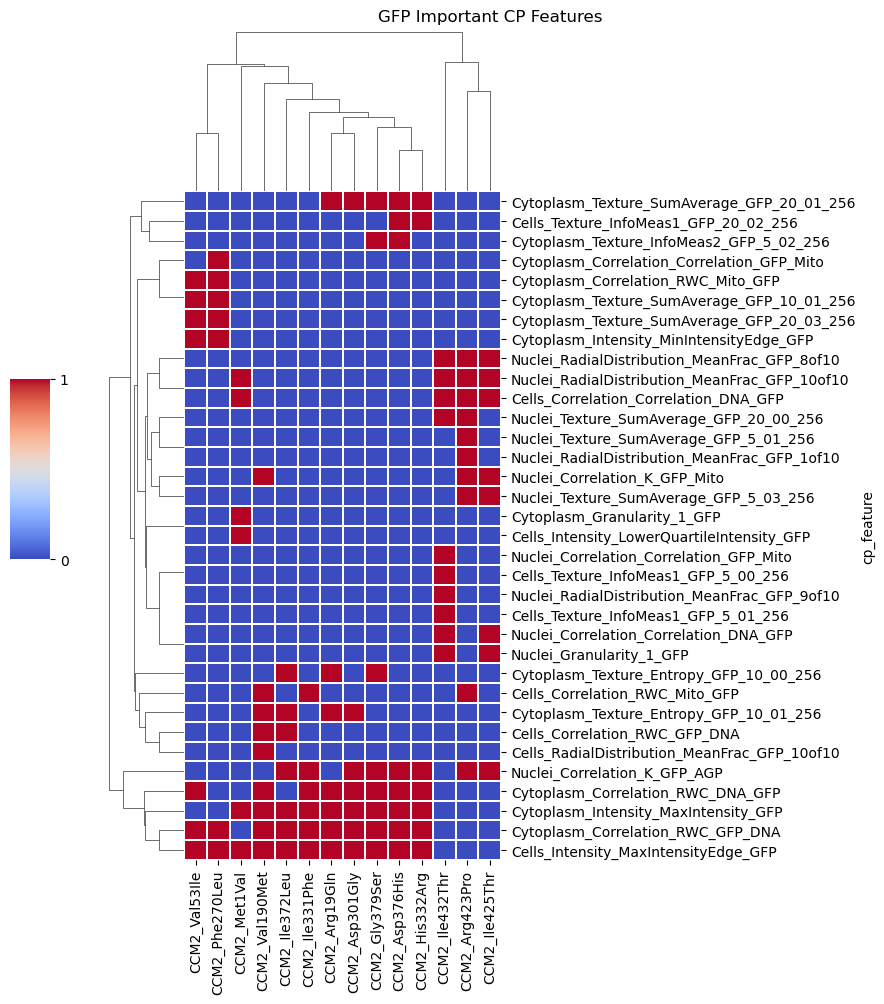

In [72]:
for feat in tqdm(["GFP"]): ## "DNA","Mito","AGP","Morph"
    gene_variant_scores = imaging_summary_clinvar.filter((pl.col("gene_allele").str.contains(gene))&(pl.col(f"Altered_95th_perc_{feat}").is_not_null()))
    variant_list = list(gene_variant_scores["gene_allele"]) + [gene]
    bio_reps = list(gene_variant_scores["Metadata_Bio_Batch"].unique())
    gene_variant_scores_hits = imaging_summary_clinvar.filter((pl.col("gene_allele").str.contains(gene))&(pl.col(f"Altered_95th_perc_{feat}")==1))
    gene_variant_scores_hits
    
    ## classification results in SM pipeline
    SM_CLASS_RES_DIR = "../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/classification_results/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells"
    feat_import_df_feat = pl.DataFrame()
    for bio_rep in bio_reps:
        bio_rep_batches = BIO_REP_BATCHES_DICT[bio_rep]
        for batch_id in bio_rep_batches:
            # Read the data
            feat_df = pl.read_csv(f"{SM_CLASS_RES_DIR.format(batch_id=batch_id)}/feat_importance.csv")
            meta_cols = [c for c in feat_df.columns if c.startswith("Metadata_") or c.startswith("Group") or c == "Batch"]
            feat_cols = [c for c in feat_df.columns if c not in meta_cols]
            feat_df = feat_df.with_columns([
                pl.col(c).cast(pl.Float64) for c in feat_cols
            ])
            feat_df = feat_df.with_columns(
                pl.lit(batch_id).alias("Metadata_Batch"),
                pl.col("Group2").str.split('_').list.slice(-2).list.join("_").alias("Metadata_gene_allele")
            )
            if feat != "Morph":
                feat_cols = [
                    i
                    for i in feat_cols
                    if (feat.lower() in i.lower())
                    and ("Brightfield" not in i) ## excluding Brightfield features
                ]
            else:
                feat_cols = [
                    i
                    for i in feat_cols
                    if ("GFP" not in i) and ("Brightfield" not in i)
                ]
            feat_df_batch = feat_df.filter(
                (pl.col("Metadata_Feature_Type")==feat)&(~pl.col("Metadata_Control"))&(pl.col("Group1").is_in(variant_list)|(pl.col("Metadata_gene_allele").is_in(variant_list)))
            ).select(meta_cols + feat_cols + ["Metadata_Batch", "Metadata_gene_allele"])
            feat_import_df_feat = pl.concat([feat_import_df_feat, feat_df_batch], how="diagonal")
    
    
    key_alleles_df = gene_variant_scores_hits.to_pandas()
    feat_df = pl.DataFrame()
    
    for j, allele in key_alleles_df.iterrows():
        # display(allele)
        batch_list = list(feat_import_df_feat.filter(pl.col("Metadata_gene_allele")==allele["gene_allele"]).unique("Metadata_Batch")["Metadata_Batch"])
        allele_df = pl.DataFrame()
        for i, batch in enumerate(batch_list):
            batch_df = feat_import_df_feat.filter((pl.col("Metadata_Batch")==batch)&(pl.col("Metadata_gene_allele")==allele["gene_allele"]))
            non_null_gfp = [col for col in batch_df.columns if not batch_df[col].is_null().any() and "Metadata" not in col and "Group" not in col]
            batch_df_col = plot_top_n_important_feat(batch_df.to_pandas(), non_null_gfp, n=5, title="B"+batch.split("_")[-1]+"_"+allele["gene_allele"])
            if not allele_df.is_empty():
                allele_df = allele_df.join(
                    pl.DataFrame(batch_df_col.reset_index()).with_columns(
                        pl.col("mean").alias(batch),
                    ).select("index", batch),
                    on="index",
                    how="full",
                    coalesce=True
                )
            else:
                allele_df = pl.DataFrame(batch_df_col.reset_index()).with_columns(
                    pl.col("mean").alias(batch)
                ).select("index", batch)
            # break
        allele_df = allele_df.with_columns(
            pl.mean_horizontal(pl.col([col for col in allele_df.columns if "Batch" in col])).alias("feat_importance"),
            pl.col("index").alias("cp_feature")
        ).select(
            pl.col(["cp_feature", "feat_importance"])
        ).rename(
            {"feat_importance": allele["gene_allele"]}
        )
        if not feat_df.is_empty():
            feat_df = feat_df.join(
                allele_df,
                left_on="cp_feature",
                right_on="cp_feature",
                how="full",
                coalesce=True
            )
        else:
            feat_df = allele_df
    
    g = sns.clustermap(
        feat_df.to_pandas().set_index("cp_feature").fillna(0)>0,
        cmap="coolwarm",
        # square=True,
        # ax=ax,
        linewidths=0.2,         # <-- width of the cell borders
        linecolor='white',       # <-- color of the borders
        col_cluster=True,
        figsize=(8,10),
        cbar_pos=(-0.1, 0.45, 0.05, 0.18),
        cbar_kws={
            "ticks": [0, 1],        # ← only show 0 and 1
            "format": "%d",         # integer formatting
        }
    )
    g.fig.suptitle(f"{feat} Important CP Features", y=1)
    plt.savefig(f"../../3_outputs/2_results_summary/CCM2/{feat}_important_cp_feats.png", dpi=400)

100%|██████████| 1/1 [01:52<00:00, 112.99s/it]


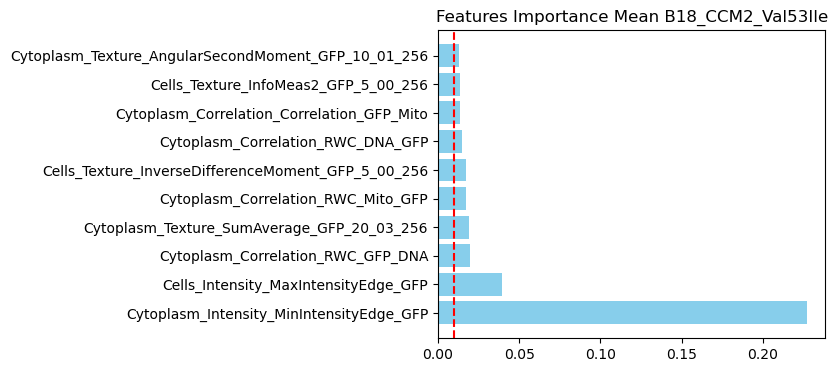

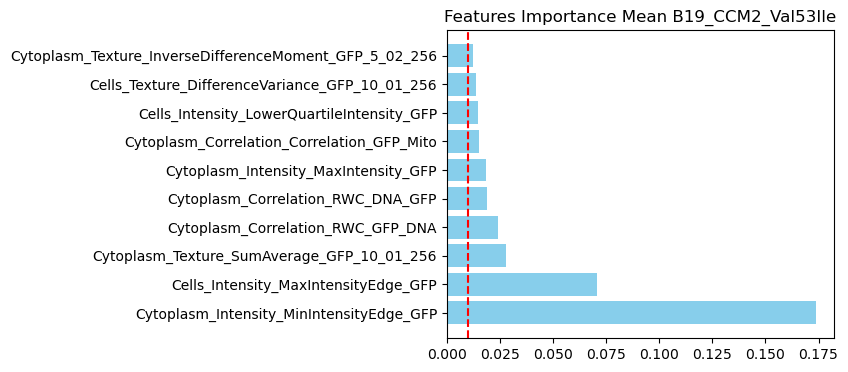

In [74]:
for feat in tqdm(["GFP"]): ## "DNA","Mito","AGP","Morph"
    gene_variant_scores = imaging_summary_clinvar.filter((pl.col("gene_allele").str.contains(gene))&(pl.col(f"Altered_95th_perc_{feat}").is_not_null()))
    variant_list = list(gene_variant_scores["gene_allele"]) + [gene]
    bio_reps = list(gene_variant_scores["Metadata_Bio_Batch"].unique())
    gene_variant_scores_hits = imaging_summary_clinvar.filter((pl.col("gene_allele").str.contains(gene))&(pl.col(f"Altered_95th_perc_{feat}")==1))
    gene_variant_scores_hits
    
    ## classification results in SM pipeline
    SM_CLASS_RES_DIR = "../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/classification_results/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells"
    feat_import_df_feat = pl.DataFrame()
    for bio_rep in bio_reps:
        bio_rep_batches = BIO_REP_BATCHES_DICT[bio_rep]
        for batch_id in bio_rep_batches:
            # Read the data
            feat_df = pl.read_csv(f"{SM_CLASS_RES_DIR.format(batch_id=batch_id)}/feat_importance.csv")
            meta_cols = [c for c in feat_df.columns if c.startswith("Metadata_") or c.startswith("Group") or c == "Batch"]
            feat_cols = [c for c in feat_df.columns if c not in meta_cols]
            feat_df = feat_df.with_columns([
                pl.col(c).cast(pl.Float64) for c in feat_cols
            ])
            feat_df = feat_df.with_columns(
                pl.lit(batch_id).alias("Metadata_Batch"),
                pl.col("Group2").str.split('_').list.slice(-2).list.join("_").alias("Metadata_gene_allele")
            )
            if feat != "Morph":
                feat_cols = [
                    i
                    for i in feat_cols
                    if (feat.lower() in i.lower())
                    and ("Brightfield" not in i) ## excluding Brightfield features
                ]
            else:
                feat_cols = [
                    i
                    for i in feat_cols
                    if ("GFP" not in i) and ("Brightfield" not in i)
                ]
            feat_df_batch = feat_df.filter(
                (pl.col("Metadata_Feature_Type")==feat)&(~pl.col("Metadata_Control"))&(pl.col("Group1").is_in(variant_list)|(pl.col("Metadata_gene_allele").is_in(variant_list)))
            ).select(meta_cols + feat_cols + ["Metadata_Batch", "Metadata_gene_allele"])
            feat_import_df_feat = pl.concat([feat_import_df_feat, feat_df_batch], how="diagonal")
    
    
    key_alleles_df = gene_variant_scores_hits.to_pandas()
    feat_df = pl.DataFrame()
    
    for j, allele in key_alleles_df.iterrows():
        # display(allele)
        batch_list = list(feat_import_df_feat.filter(pl.col("Metadata_gene_allele")==allele["gene_allele"]).unique("Metadata_Batch")["Metadata_Batch"])
        allele_df = pl.DataFrame()
        for i, batch in enumerate(batch_list):
            if allele["gene_allele"] != "CCM2_Val53Ile":
                continue
            batch_df = feat_import_df_feat.filter((pl.col("Metadata_Batch")==batch)&(pl.col("Metadata_gene_allele")==allele["gene_allele"]))
            non_null_gfp = [col for col in batch_df.columns if not batch_df[col].is_null().any() and "Metadata" not in col and "Group" not in col]
            batch_df_col = plot_top_n_important_feat(batch_df.to_pandas(), non_null_gfp, n=10, plot=True, title="B"+batch.split("_")[-1]+"_"+allele["gene_allele"])
            
    #         if not allele_df.is_empty():
    #             allele_df = allele_df.join(
    #                 pl.DataFrame(batch_df_col.reset_index()).with_columns(
    #                     pl.col("mean").alias(batch),
    #                 ).select("index", batch),
    #                 on="index",
    #                 how="full",
    #                 coalesce=True
    #             )
    #         else:
    #             allele_df = pl.DataFrame(batch_df_col.reset_index()).with_columns(
    #                 pl.col("mean").alias(batch)
    #             ).select("index", batch)
    #         # break
    #     allele_df = allele_df.with_columns(
    #         pl.mean_horizontal(pl.col([col for col in allele_df.columns if "Batch" in col])).alias("feat_importance"),
    #         pl.col("index").alias("cp_feature")
    #     ).select(
    #         pl.col(["cp_feature", "feat_importance"])
    #     ).rename(
    #         {"feat_importance": allele["gene_allele"]}
    #     )
    #     if not feat_df.is_empty():
    #         feat_df = feat_df.join(
    #             allele_df,
    #             left_on="cp_feature",
    #             right_on="cp_feature",
    #             how="full",
    #             coalesce=True
    #         )
    #     else:
    #         feat_df = allele_df
    
    # g = sns.clustermap(
    #     feat_df.to_pandas().set_index("cp_feature").fillna(0)>0,
    #     cmap="coolwarm",
    #     # square=True,
    #     # ax=ax,
    #     linewidths=0.2,         # <-- width of the cell borders
    #     linecolor='white',       # <-- color of the borders
    #     col_cluster=True,
    #     figsize=(8,10),
    #     cbar_pos=(-0.1, 0.45, 0.05, 0.18),
    #     cbar_kws={
    #         "ticks": [0, 1],        # ← only show 0 and 1
    #         "format": "%d",         # integer formatting
    #     }
    # )
    # g.fig.suptitle(f"{feat} Important CP Features", y=1)
    # plt.savefig(f"../../3_outputs/2_results_summary/CCM2/{feat}_important_cp_feats.png", dpi=400)

### 2.2 Profile Analyses

In [204]:
## QC-ed PQ files
ALL_PROF_QC = "../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier.parquet"
PASS_QC_PROF_PQ = "../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"

In [205]:
# Paths
ref_var_cell_qc_prof_df = pl.DataFrame()
target_gene_alleles = []
meta_cols = [
    "Metadata_CellID",
    "Metadata_gene_allele",
    "Metadata_Well",
    "Metadata_Plate",
    "Metadata_node_type"
]

# Get meta features
for bio_rep in bio_reps:
    bio_rep_batches = BIO_REP_BATCHES_DICT[bio_rep]
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                PASS_QC_PROF_PQ.format(batch_id=batch_id)
            )
            .filter(pl.col("Metadata_gene_allele").is_in(variant_list))
            .with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID")
            )
        ).collect()
        # feat_cols = [col for col in batch_alleles.columns if ("AGP".lower() in col.lower() or "DNA".lower() in col.lower() or "Mito".lower() in col.lower()) and ("GFP".lower() not in col.lower())]
        batch_alleles = batch_alleles.join(
            img_well_qc_sum_dict[bio_rep].filter(pl.col("channel")==feat).select(pl.col("plate", "well", "is_bg")),
            left_on=["Metadata_Plate", "Metadata_Well"],
            right_on=["plate", "well"]
        ).filter(
            ~pl.col("is_bg")
        ).select(pl.col(meta_cols))
        ref_var_cell_qc_prof_df = pl.concat([ref_var_cell_qc_prof_df, batch_alleles], how="diagonal_relaxed")

In [206]:
# Paths
ref_var_cell_all_prof_list = []
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                ALL_PROF_QC.format(batch_id=batch_id)
            )
            .filter(pl.col("Metadata_gene_allele").is_in(variant_list))
            .with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID")
            )
        )
        ref_var_cell_all_prof_list.append(batch_alleles)

# all_feat_cols = [i for i in ref_var_cell_all_prof_list[0].collect_schema() if feat.lower() in i.lower() and "Brightfield" not in i]
if feat == "Morph":
    all_feat_cols = reduce(set.intersection, map(set, [[col for col in ref_var_cell_all_prof.collect_schema() if ("AGP".lower() in col.lower() or "DNA".lower() in col.lower() or "Mito".lower() in col.lower()) \
                                                    and ("Brightfield".lower() not in col.lower() and "GFP".lower() not in col.lower())] for ref_var_cell_all_prof in ref_var_cell_all_prof_list]))
else:
    all_feat_cols = reduce(set.intersection, map(set, [[col for col in ref_var_cell_all_prof.collect_schema() if (feat.lower() in col.lower()) and ("Brightfield".lower() not in col.lower())] for ref_var_cell_all_prof in ref_var_cell_all_prof_list]))
    
select_cols = list(all_feat_cols) + ["Metadata_CellID"]
ref_var_cell_all_prof_df = pl.concat([batch_alleles.select(select_cols).collect() for batch_alleles in ref_var_cell_all_prof_list])
# This method of joining ensures that only cells past filters are included in the abundance analysis
ref_var_cell_all_prof_df = ref_var_cell_qc_prof_df.join(ref_var_cell_all_prof_df, 
                                                        on="Metadata_CellID", how="left", coalesce=True)

In [85]:
ref_var_cell_all_prof_df = ref_var_cell_all_prof_df.with_columns(
    pl.col("Metadata_Plate")
      # capture a “B” followed by any non-underscore chars up to the first “A”
      .str.extract(r"(B[^_]*?A)", 1)
      .alias("Metadata_Batch")
).with_columns(
    pl.col("Metadata_Batch").replace(BIO_BATCH_MAP_BIO_REP).alias("Metadata_Bio_Batch")
)

ref_var_allele_batch_all_prof_df = ref_var_cell_all_prof_df.group_by(
    "Metadata_Plate", "Metadata_Well", "Metadata_gene_allele", "Metadata_Bio_Batch"
).agg(
    pl.col(col).median().alias(col)
    for col in all_feat_cols
    if not col.startswith("Metadata_")
).group_by(
    "Metadata_gene_allele", "Metadata_Bio_Batch"
).agg(
    pl.col(col).median().alias(col)
    for col in all_feat_cols
    if not col.startswith("Metadata_")
).unique(subset=["Metadata_gene_allele","Metadata_Bio_Batch"])

non_null_cols_batch = [col for col in ref_var_allele_batch_all_prof_df.columns if not ref_var_allele_batch_all_prof_df[col].is_null().any() and "Metadata" not in col]
var_allele_meta_cols = [col for col in ref_var_allele_batch_all_prof_df.columns if "Metadata" in col]
ref_var_allele_batch_all_prof_df = ref_var_allele_batch_all_prof_df.select(
    var_allele_meta_cols+non_null_cols_batch
)
ref_var_allele_batch_all_prof_df

shape: (173, 494)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Metadata_ ┆ Metadata_ ┆ Cytoplasm ┆ Cells_Tex ┆ … ┆ Cytoplasm ┆ Nuclei_Te ┆ Cytoplasm ┆ Nuclei_T │
│ gene_alle ┆ Bio_Batch ┆ _Granular ┆ ture_SumA ┆   ┆ _Texture_ ┆ xture_Sum ┆ _Granular ┆ exture_S │
│ le        ┆ ---       ┆ ity_7_GFP ┆ verage_GF ┆   ┆ InfoMeas1 ┆ Average_G ┆ ity_2_GFP ┆ umAverag │
│ ---       ┆ str       ┆ ---       ┆ P_2…      ┆   ┆ _GF…      ┆ FP_…      ┆ ---       ┆ e_GFP_…  │
│ str       ┆           ┆ f32       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f32       ┆ ---      │
│           ┆           ┆           ┆ f32       ┆   ┆ f32       ┆ f32       ┆           ┆ f32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ CCM2_Ser3 ┆ 2025_01_B ┆ 0.846027  ┆ 1.86811   ┆ … ┆ -0.584405 ┆ 1.280483  ┆ -0.11929  ┆ 1.600967 │
│ 30Phe     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ala4 ┆ 2025_01_B ┆ 0.117593  ┆ 1.945013  ┆ … ┆ -0.752849 ┆ 1.270978  ┆ -0.075609 ┆ 1.553086 │
│ 05Ser     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Cys1 ┆ 2025_01_B ┆ -0.001255 ┆ 0.56198   ┆ … ┆ -0.413865 ┆ 0.414748  ┆ 0.039653  ┆ 0.295789 │
│ 70Tyr     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ala1 ┆ 2025_01_B ┆ -0.21538  ┆ 0.108222  ┆ … ┆ -0.284105 ┆ 0.056616  ┆ -0.162552 ┆ -0.08295 │
│ 49Thr     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ala2 ┆ 2025_01_B ┆ 0.20301   ┆ 0.067582  ┆ … ┆ -0.183394 ┆ 0.044749  ┆ 0.110887  ┆ -0.10626 │
│ 05Thr     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ CCM2_Glu3 ┆ 2025_01_B ┆ -0.06057  ┆ 0.852316  ┆ … ┆ -0.457707 ┆ 0.524418  ┆ -0.113497 ┆ 0.473323 │
│ 33Val     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ser1 ┆ 2025_01_B ┆ -0.364557 ┆ 0.613588  ┆ … ┆ -0.460388 ┆ 0.36325   ┆ -0.176632 ┆ 0.241957 │
│ 43Phe     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Asp4 ┆ 2025_01_B ┆ 0.601843  ┆ 1.372     ┆ … ┆ -0.577426 ┆ 1.160207  ┆ 0.052874  ┆ 1.230406 │
│ 19Tyr     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Pro1 ┆ 2025_01_B ┆ 0.418585  ┆ 0.714239  ┆ … ┆ -0.320971 ┆ 0.495305  ┆ 0.011112  ┆ 0.521685 │
│ 02Ser     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Arg4 ┆ 2025_01_B ┆ -0.051713 ┆ 0.876085  ┆ … ┆ -0.501407 ┆ 0.620408  ┆ -0.032196 ┆ 0.551252 │
│ 12Gln     ┆ atch_13-1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴──────

In [93]:
## normalize the features
ref_var_allele_batch_proc_prof_df = inverse_normal_transform(ref_var_allele_batch_all_prof_df)
## remove corr features
ref_var_allele_batch_proc_prof_df = remove_corr_feats(ref_var_allele_batch_proc_prof_df, corr_thres=0.9)
non_null_cols_batch = [col for col in ref_var_allele_batch_proc_prof_df.columns if not ref_var_allele_batch_proc_prof_df[col].is_null().any() and "Metadata" not in col]
# print(non_null_cols_batch)
ref_var_allele_batch_proc_prof_df = ref_var_allele_batch_proc_prof_df.select(
    var_allele_meta_cols + [col for col in non_null_cols_batch if ref_var_allele_batch_all_prof_df.select(pl.col(col).std()).item() != 0]
)

var_allele_batch_proc_prof_df = ref_var_allele_batch_proc_prof_df.join(
    gene_variant_scores.select(
        [
            "gene_allele", "Metadata_Bio_Batch",
            f"Altered_95th_perc_{feat}", f"AUROC_Mean_{feat}",
            "clinvar_clnsig_clean"
        ]
    ), 
    left_on=["Metadata_gene_allele", "Metadata_Bio_Batch"],
    right_on=["gene_allele", "Metadata_Bio_Batch"],
    how="inner"
).with_columns(
    pl.col(f"Altered_95th_perc_{feat}").cast(pl.Boolean).alias(f"{feat}_Changed")
)

ref_allele_batch_proc_prof_df = ref_var_allele_batch_proc_prof_df.filter(
    ~pl.col("Metadata_gene_allele").str.contains("_")
).group_by(
    "Metadata_gene_allele", "Metadata_Bio_Batch"
).agg(
    pl.col(col).median().alias(col)
    for col in ref_var_allele_batch_proc_prof_df.columns
    if not col.startswith("Metadata_")
)

ref_var_allele_batch_proc_prof_df = pl.concat([
    var_allele_batch_proc_prof_df,
    ref_allele_batch_proc_prof_df,
], how="diagonal").with_columns(
    pl.col(f"{feat}_Changed").fill_null(False),
    pl.col("clinvar_clnsig_clean").fill_null("6_No_ClinVar"),
    pl.col(f"AUROC_Mean_{feat}").fill_null(0)
)

In [91]:
ref_var_allele_batch_proc_prof_df.shape

(173, 79)

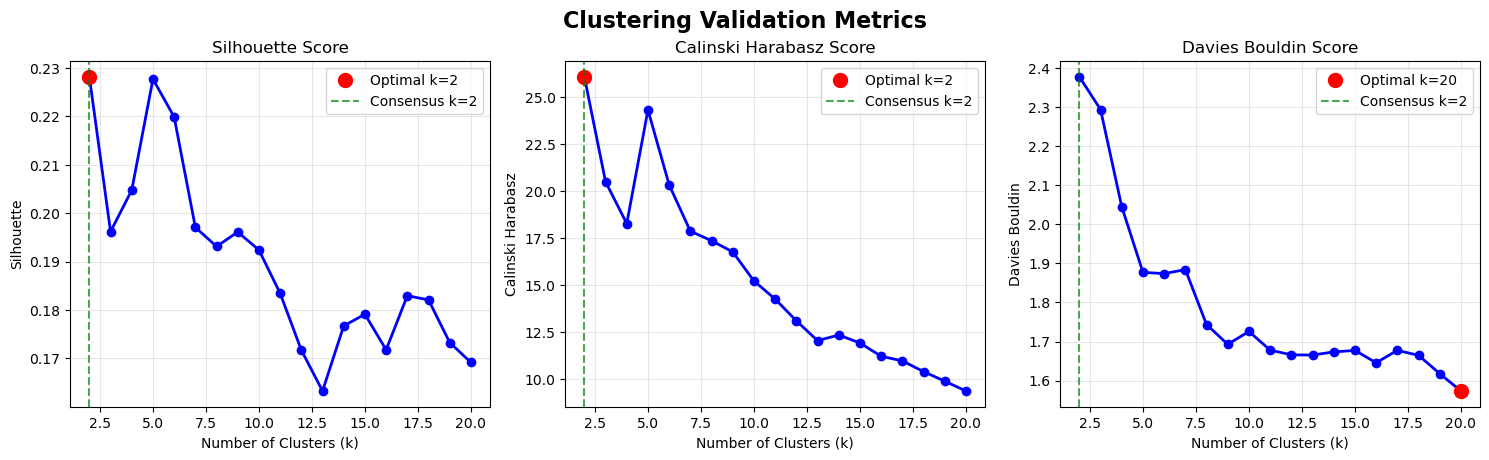

Optimal cluster selection results:
Consensus optimal k: 2
Method-specific optimal k values: {'silhouette': 2, 'calinski_harabasz': 2, 'davies_bouldin': 20, 'elbow': 5}
Consensus votes: {2: 2, 20: 1, 5: 1}


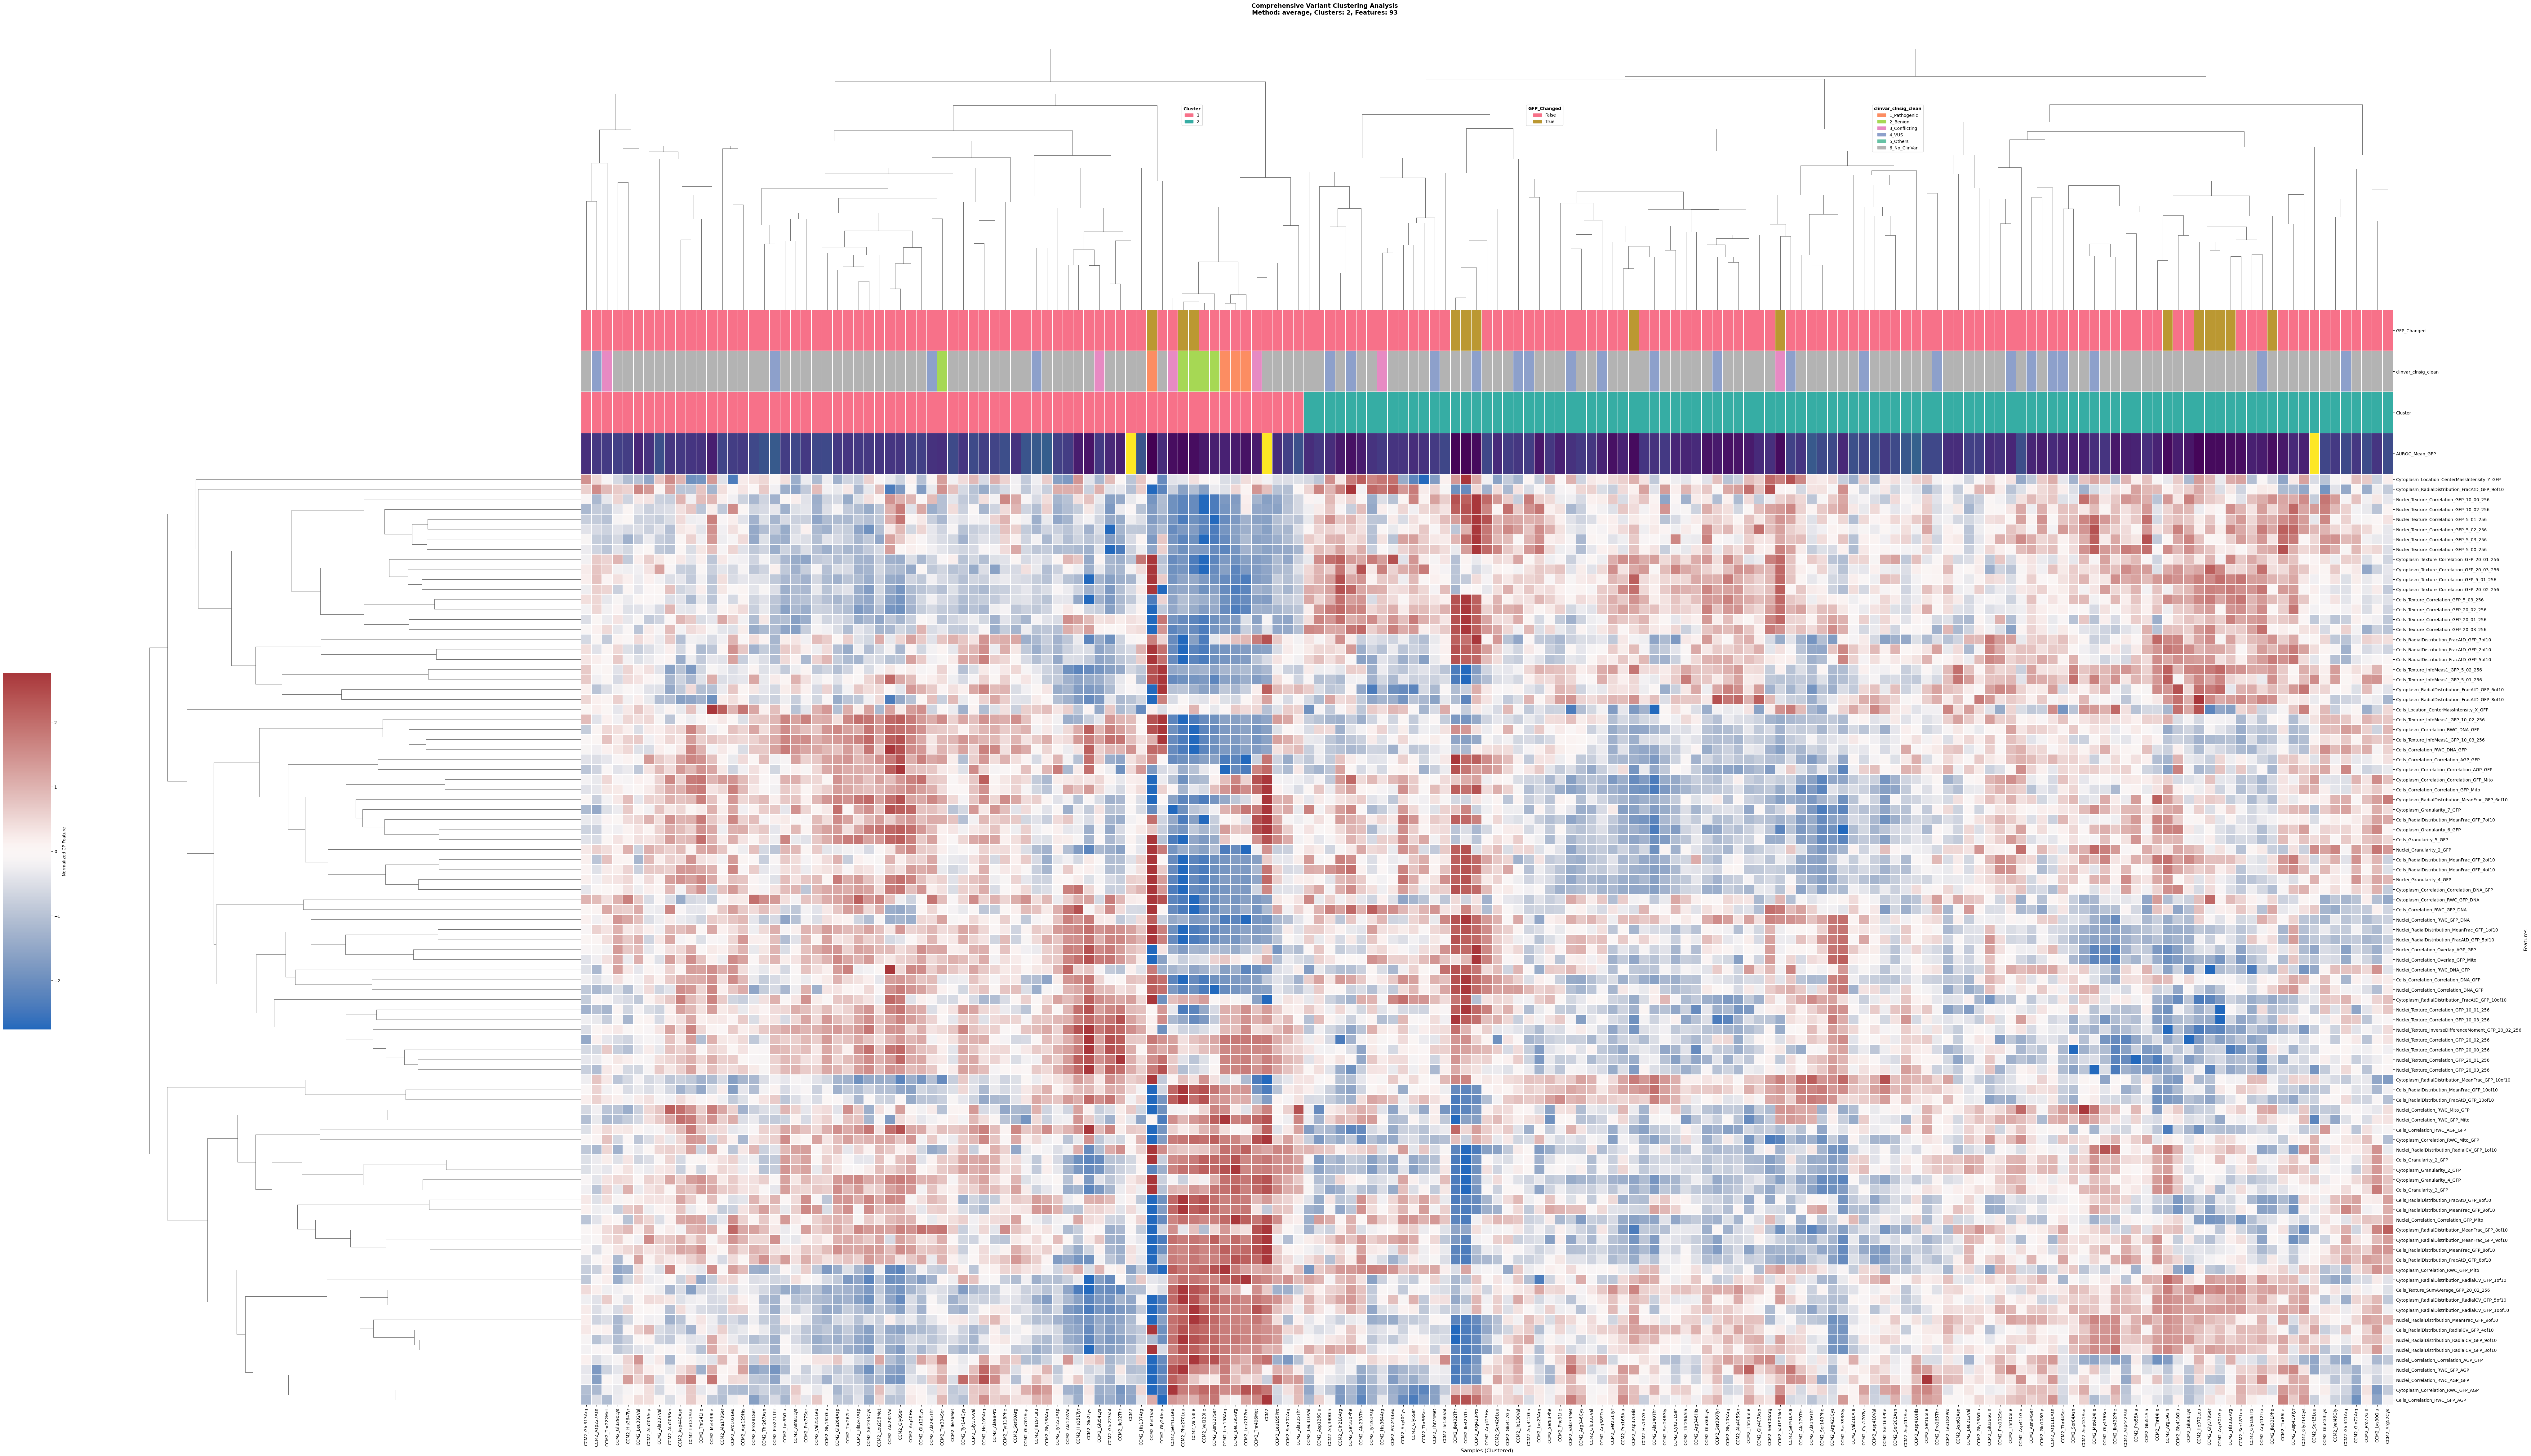

/home/shenrunx/software/anaconda3/envs/ai4protein/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


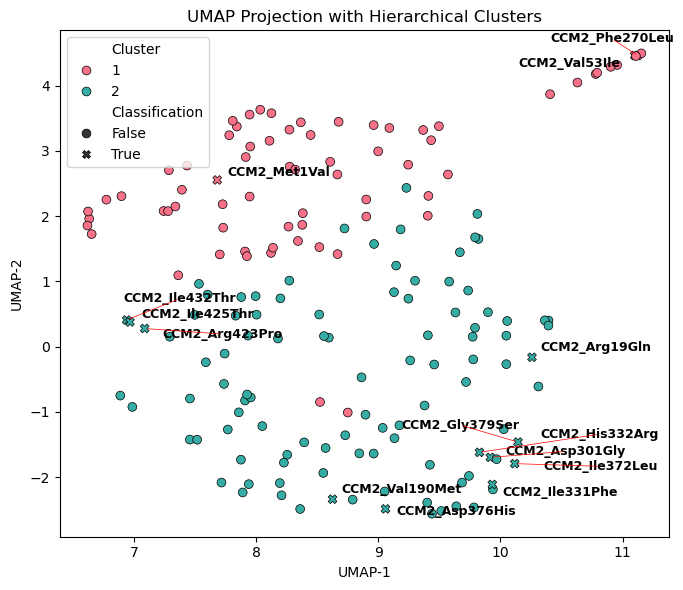

In [98]:
results_var_wt = robust_cosine_clustering_with_annotations(ref_var_allele_batch_proc_prof_df.to_pandas().set_index("Metadata_gene_allele"),
                                                    feature_cols=[col for col in non_null_cols_batch if col in ref_var_allele_batch_proc_prof_df.columns],
                                                    annotation_cols=[f"{feat}_Changed", "clinvar_clnsig_clean"],
                                                    continuous_annotations=[f"AUROC_Mean_{feat}"])

clustermap_var_wt = create_comprehensive_clustermap(ref_var_allele_batch_proc_prof_df.to_pandas().set_index("Metadata_gene_allele"), 
                                                    results_var_wt, 
                                                    title_label=f"{gene}_{feat}_var_and_ref",
                                                    save_path="")

### WRT to Ref

In [105]:
## Normalize var per batch
var_allele_prof_wrt_ref_df = pl.DataFrame()
for batch in ref_var_allele_batch_all_prof_df["Metadata_Bio_Batch"].unique():
    ref_var_allele_all_prof_batch = ref_var_allele_batch_all_prof_df.filter(
        pl.col("Metadata_Bio_Batch")==batch
    )
    batch_feat_cols = [col for col in ref_var_allele_all_prof_batch.columns if "Metadata" not in col]
    ## INT normalization per batch
    # ref_var_allele_all_prof_batch = inverse_normal_transform(ref_var_allele_all_prof_batch)
    batch_ref = ref_var_allele_all_prof_batch.filter(
        (~pl.col("Metadata_gene_allele").str.contains("_"))
    ).to_pandas().set_index("Metadata_gene_allele")[batch_feat_cols]
    # display(batch_ref)
    batch_var = ref_var_allele_all_prof_batch.filter(
        (pl.col("Metadata_gene_allele").str.contains("_"))
    ).to_pandas().set_index("Metadata_gene_allele")[batch_feat_cols]
    # display(batch_var)
    batch_var = batch_var - batch_ref.loc[gene]
    # display(batch_var)
    var_allele_prof_wrt_ref_df = pl.concat([
        var_allele_prof_wrt_ref_df, 
        pl.DataFrame(
            batch_var.reset_index()
        ).with_columns(
            pl.lit(batch).alias("Metadata_Bio_Batch")
        )
    ])

In [106]:
var_allele_prof_wrt_ref_df = inverse_normal_transform(var_allele_prof_wrt_ref_df)
var_allele_prof_wrt_ref_df = remove_corr_feats(var_allele_prof_wrt_ref_df)

non_null_cols_batch = [col for col in var_allele_prof_wrt_ref_df.columns if not var_allele_prof_wrt_ref_df[col].is_null().any() and "Metadata" not in col]
var_allele_meta_cols = [col for col in var_allele_prof_wrt_ref_df.columns if "Metadata" in col]
var_allele_prof_wrt_ref_df = var_allele_prof_wrt_ref_df.select(
    var_allele_meta_cols + [col for col in non_null_cols_batch if var_allele_prof_wrt_ref_df.select(pl.col(col).std()).item() != 0]
)

In [107]:
var_allele_prof_wrt_ref_df = var_allele_prof_wrt_ref_df.join(
    gene_variant_scores.select(
        [
            "gene_allele", "Metadata_Bio_Batch",
            f"Altered_95th_perc_{feat}", f"AUROC_Mean_{feat}",
            "clinvar_clnsig_clean"
        ]
    ), 
    left_on=["Metadata_gene_allele", "Metadata_Bio_Batch"],
    right_on=["gene_allele", "Metadata_Bio_Batch"],
    how="inner"
).with_columns(
    pl.col(f"Altered_95th_perc_{feat}").cast(pl.Boolean).alias(f"{feat}_Changed")
).with_columns(
    pl.col(f"{feat}_Changed").fill_null(False)
)

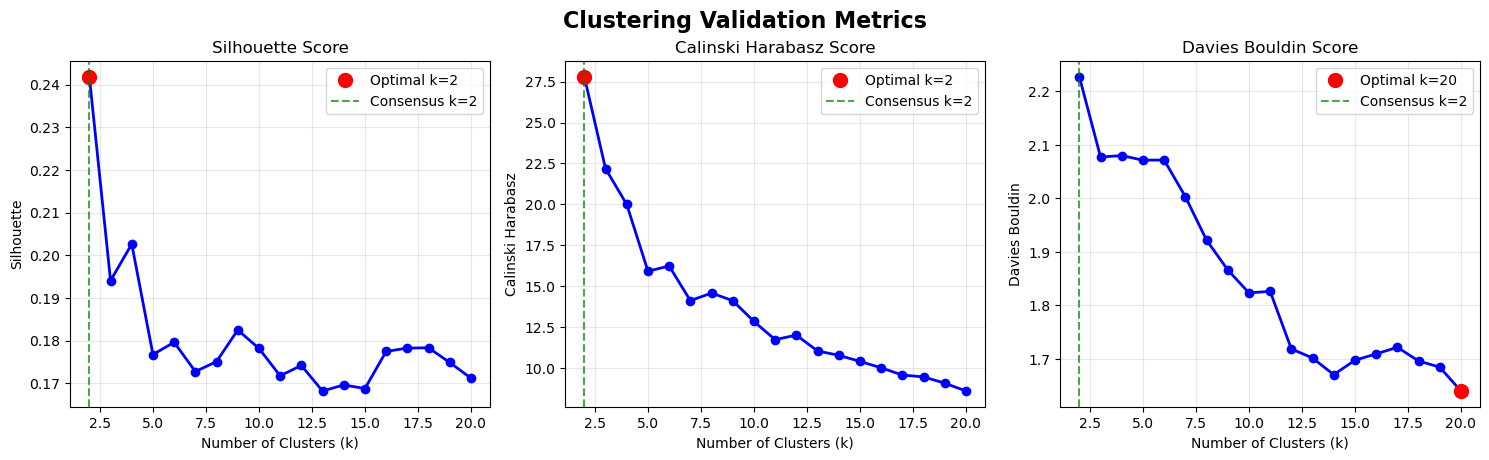

Optimal cluster selection results:
Consensus optimal k: 2
Method-specific optimal k values: {'silhouette': 2, 'calinski_harabasz': 2, 'davies_bouldin': 20, 'elbow': 4}
Consensus votes: {2: 2, 20: 1, 4: 1}


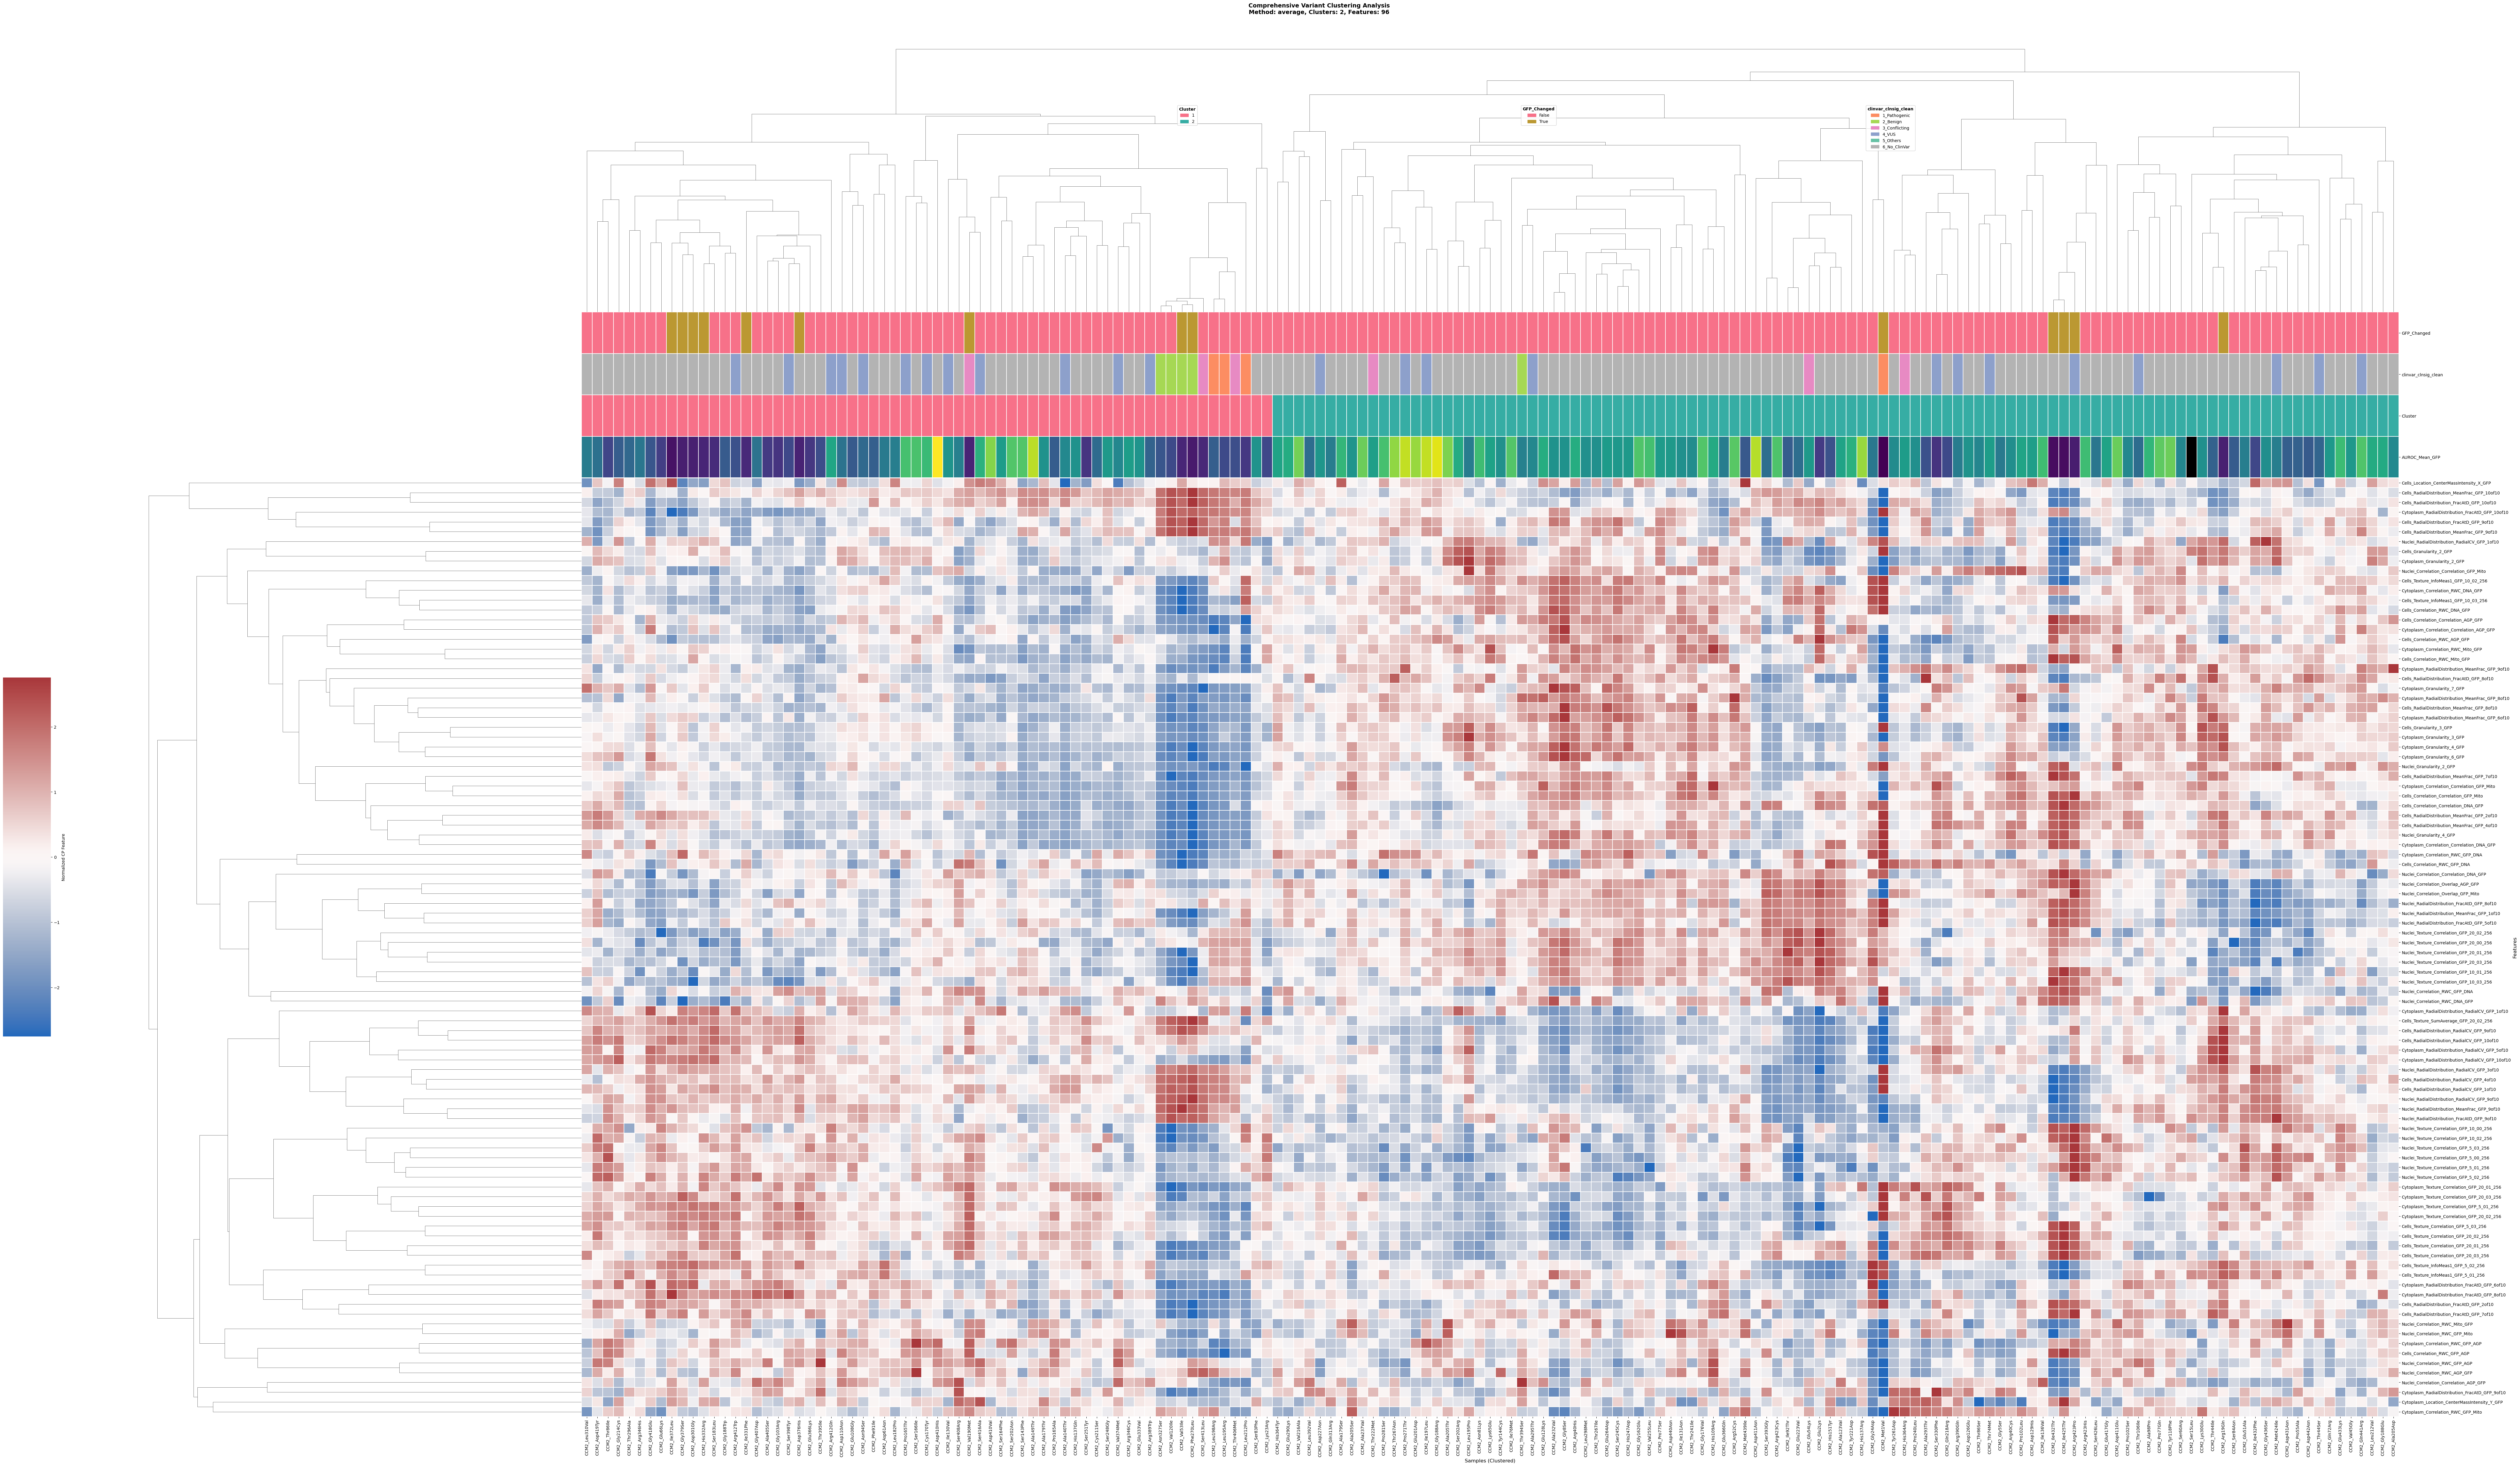

/home/shenrunx/software/anaconda3/envs/ai4protein/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


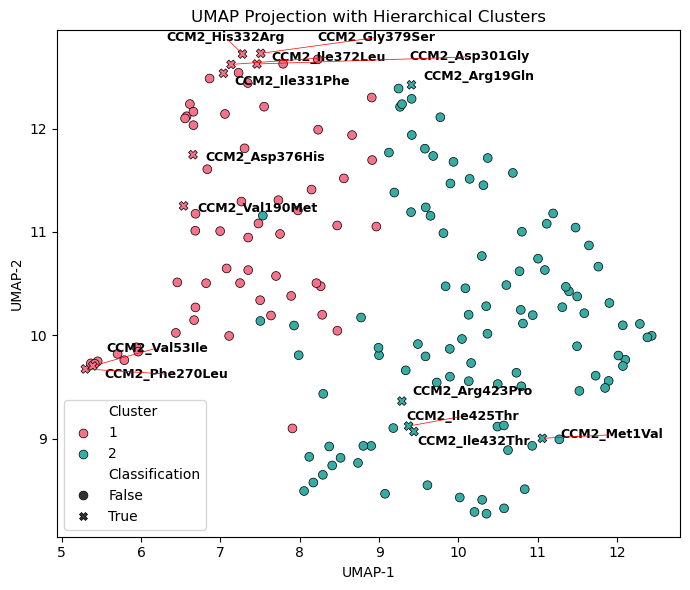

In [108]:
results_var2wt = robust_cosine_clustering_with_annotations(var_allele_prof_wrt_ref_df.to_pandas().set_index("Metadata_gene_allele"),
                                                           feature_cols=[col for col in non_null_cols_batch if col in var_allele_prof_wrt_ref_df.columns],
                                                           annotation_cols=[f"{feat}_Changed", "clinvar_clnsig_clean"],
                                                           continuous_annotations=[f"AUROC_Mean_{feat}"])
clustermap_var2wt = create_comprehensive_clustermap(var_allele_prof_wrt_ref_df.to_pandas().set_index("Metadata_gene_allele"), 
                                                    results_var2wt, title_label=f"{gene}_{feat}_norm_var_wrt_ref",
                                                    save_path="") #"/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP_imgs"

In [135]:
clustermap_var2wt[clustermap_var2wt["Classification"]].sort_values("Cluster")

UMAP-1     UMAP-2  Cluster  Classification
Metadata_gene_allele                                               
CCM2_Phe270Leu         5.296140   9.673665        1            True
CCM2_Gly379Ser         7.508139  12.727234        1            True
CCM2_Ile372Leu         7.133417  12.619710        1            True
CCM2_Asp376His         6.653228  11.746610        1            True
CCM2_Ile331Phe         7.037245  12.534757        1            True
CCM2_Val190Met         6.535494  11.251472        1            True
CCM2_Val53Ile          5.388442   9.702434        1            True
CCM2_His332Arg         7.277820  12.720931        1            True
CCM2_Asp301Gly         7.460030  12.624232        1            True
CCM2_Arg19Gln          9.408499  12.422888        2            True
CCM2_Ile425Thr         9.372372   9.121217        2            True
CCM2_Ile432Thr         9.439522   9.068260        2            True
CCM2_Arg423Pro         9.287921   9.362877        2            True
CCM2_Met1Val          11.058779   9.002776        2            True

## 3. Protein Structure

In [61]:
import requests
import glob
import gzip
import re
import os
import numpy as np
import py3Dmol
import polars as pl
from Bio.PDB import PDBParser
from Bio.SubsMat import MatrixInfo
from sklearn.cluster import AgglomerativeClustering

/home/shenrunx/software/anaconda3/envs/ai4protein/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [62]:
def get_uniprot_swissprot_id(protein_name: str) -> str:
    """
    Query UniProt’s REST search API to find the reviewed (Swiss‐Prot) accession
    for a given human gene/protein name. Returns None if not found.
    """
    url = "https://rest.uniprot.org/uniprotkb/search"
    # Build a query that:
    #  - matches the gene name exactly (using “gene:”)
    #  - restricts to human (organism_id:9606)
    #  - restricts to reviewed (Swiss‐Prot) entries
    query = f"gene:{protein_name} AND organism_id:9606 AND reviewed:true"
    params = {
        "query": query,
        "fields": "accession",
        "format": "json",
        "size": 1,      # only need the top hit
    }
    try:
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        data = resp.json()
        results = data.get("results", [])
        if not results:
            return None
        return results[0]["primaryAccession"]
    except Exception:
        # If the request fails (e.g. no internet), return None
        return None

In [63]:
gene_uniprot_id = get_uniprot_swissprot_id(gene)
print(f"UniProt Swiss‐Prot ID for {gene}:", {gene_uniprot_id} or "Not found")

af2_struc_pdb_dir = "/data/shenrunx/igvf/varchamp/2025_laval_submitted/compare_ai_scores/1_inputs/new_raw_data/alphafold/UP000005640_9606_HUMAN_v4"

pdb_file = [pdb for pdb in glob.glob(f"{af2_struc_pdb_dir}/*.pdb.gz") if gene_uniprot_id in pdb][0]
pdb_file

UniProt Swiss‐Prot ID for BRCA1: {'P38398'}


'/data/shenrunx/igvf/varchamp/2025_laval_submitted/compare_ai_scores/1_inputs/new_raw_data/alphafold/UP000005640_9606_HUMAN_v4/AF-P38398-F1-model_v4.pdb.gz'

In [64]:
import pandas as pd

# 3-letter to 1-letter AA conversion dictionary
three_to_one = {
    'ALA':'A', 'ARG':'R', 'ASN':'N', 'ASP':'D', 'CYS':'C',
    'GLN':'Q', 'GLU':'E', 'GLY':'G', 'HIS':'H', 'ILE':'I',
    'LEU':'L', 'LYS':'K', 'MET':'M', 'PHE':'F', 'PRO':'P',
    'SER':'S', 'THR':'T', 'TRP':'W', 'TYR':'Y', 'VAL':'V'
}

# Load BLOSUM62 matrix from Biopython
blosum62 = MatrixInfo.blosum62

def blosum62_score(wt, mut):
    key = (wt.upper(), mut.upper())
    if key not in blosum62:
        key = (mut.upper(), wt.upper())
    return blosum62.get(key)


miyata_dist = {
    'A':{'A':0.00,'R':0.91,'N':0.83,'D':0.88,'C':1.27,'Q':0.93,'E':0.94,'G':0.60,'H':1.00,'I':1.27,'L':1.23,'K':0.99,'M':1.05,'F':1.49,'P':0.74,'S':0.58,'T':0.64,'W':1.85,'Y':1.47,'V':1.14},
    'R':{'A':0.91,'R':0.00,'N':0.77,'D':1.04,'C':1.68,'Q':0.21,'E':0.44,'G':1.27,'H':0.39,'I':1.60,'L':1.54,'K':0.25,'M':1.39,'F':1.68,'P':0.95,'S':0.87,'T':1.12,'W':1.45,'Y':1.19,'V':1.54},
    'N':{'A':0.83,'R':0.77,'N':0.00,'D':0.24,'C':1.57,'Q':0.42,'E':0.54,'G':0.80,'H':0.56,'I':1.64,'L':1.65,'K':0.80,'M':1.59,'F':1.95,'P':1.13,'S':0.26,'T':0.37,'W':2.08,'Y':1.72,'V':1.49},
    'D':{'A':0.88,'R':1.04,'N':0.24,'D':0.00,'C':1.84,'Q':0.94,'E':0.22,'G':0.89,'H':0.89,'I':1.89,'L':1.83,'K':0.89,'M':1.76,'F':2.16,'P':1.38,'S':0.50,'T':0.82,'W':2.15,'Y':1.79,'V':1.66},
    'C':{'A':1.27,'R':1.68,'N':1.57,'D':1.84,'C':0.00,'Q':1.89,'E':1.90,'G':1.70,'H':1.42,'I':1.18,'L':1.08,'K':1.89,'M':1.04,'F':1.48,'P':1.94,'S':1.16,'T':1.30,'W':1.81,'Y':1.36,'V':1.07},
    'Q':{'A':0.93,'R':0.21,'N':0.42,'D':0.94,'C':1.89,'Q':0.00,'E':0.29,'G':1.31,'H':0.45,'I':1.55,'L':1.47,'K':0.28,'M':1.24,'F':1.59,'P':1.03,'S':0.74,'T':0.90,'W':1.57,'Y':1.20,'V':1.48},
    'E':{'A':0.94,'R':0.44,'N':0.54,'D':0.22,'C':1.90,'Q':0.29,'E':0.00,'G':1.09,'H':0.73,'I':1.66,'L':1.60,'K':0.42,'M':1.44,'F':1.85,'P':1.22,'S':0.60,'T':0.86,'W':1.77,'Y':1.40,'V':1.58},
    'G':{'A':0.60,'R':1.27,'N':0.80,'D':0.89,'C':1.70,'Q':1.31,'E':1.09,'G':0.00,'H':1.40,'I':1.59,'L':1.53,'K':1.28,'M':1.50,'F':1.92,'P':0.75,'S':0.47,'T':0.58,'W':2.08,'Y':1.70,'V':1.34},
    'H':{'A':1.00,'R':0.39,'N':0.56,'D':0.89,'C':1.42,'Q':0.45,'E':0.73,'G':1.40,'H':0.00,'I':1.71,'L':1.67,'K':0.56,'M':1.52,'F':1.69,'P':1.32,'S':0.90,'T':1.06,'W':1.25,'Y':0.96,'V':1.66},
    'I':{'A':1.27,'R':1.60,'N':1.64,'D':1.89,'C':1.18,'Q':1.55,'E':1.66,'G':1.59,'H':1.71,'I':0.00,'L':0.04,'K':1.62,'M':0.16,'F':0.39,'P':1.65,'S':1.21,'T':1.04,'W':1.84,'Y':1.46,'V':0.23},
    'L':{'A':1.23,'R':1.54,'N':1.65,'D':1.83,'C':1.08,'Q':1.47,'E':1.60,'G':1.53,'H':1.67,'I':0.04,'L':0.00,'K':1.57,'M':0.22,'F':0.61,'P':1.59,'S':1.14,'T':1.01,'W':1.77,'Y':1.39,'V':0.32},
    'K':{'A':0.99,'R':0.25,'N':0.80,'D':0.89,'C':1.89,'Q':0.28,'E':0.42,'G':1.28,'H':0.56,'I':1.62,'L':1.57,'K':0.00,'M':1.41,'F':1.73,'P':1.07,'S':0.63,'T':0.83,'W':1.55,'Y':1.18,'V':1.53},
    'M':{'A':1.05,'R':1.39,'N':1.59,'D':1.76,'C':1.04,'Q':1.24,'E':1.44,'G':1.50,'H':1.52,'I':0.16,'L':0.22,'K':1.41,'M':0.00,'F':0.60,'P':1.44,'S':1.10,'T':1.03,'W':1.84,'Y':1.43,'V':0.38},
    'F':{'A':1.49,'R':1.68,'N':1.95,'D':2.16,'C':1.48,'Q':1.59,'E':1.85,'G':1.92,'H':1.69,'I':0.39,'L':0.61,'K':1.73,'M':0.60,'F':0.00,'P':1.90,'S':1.56,'T':1.57,'W':1.28,'Y':0.38,'V':0.67},
    'P':{'A':0.74,'R':0.95,'N':1.13,'D':1.38,'C':1.94,'Q':1.03,'E':1.22,'G':0.75,'H':1.32,'I':1.65,'L':1.59,'K':1.07,'M':1.44,'F':1.90,'P':0.00,'S':0.75,'T':0.76,'W':2.19,'Y':1.76,'V':1.34},
    'S':{'A':0.58,'R':0.87,'N':0.26,'D':0.50,'C':1.16,'Q':0.74,'E':0.60,'G':0.47,'H':0.90,'I':1.21,'L':1.14,'K':0.63,'M':1.10,'F':1.56,'P':0.75,'S':0.00,'T':0.17,'W':1.88,'Y':1.53,'V':1.07},
    'T':{'A':0.64,'R':1.12,'N':0.37,'D':0.82,'C':1.30,'Q':0.90,'E':0.86,'G':0.58,'H':1.06,'I':1.04,'L':1.01,'K':0.83,'M':1.03,'F':1.57,'P':0.76,'S':0.17,'T':0.00,'W':1.92,'Y':1.56,'V':0.90},
    'W':{'A':1.85,'R':1.45,'N':2.08,'D':2.15,'C':1.81,'Q':1.57,'E':1.77,'G':2.08,'H':1.25,'I':1.84,'L':1.77,'K':1.55,'M':1.84,'F':1.28,'P':2.19,'S':1.88,'T':1.92,'W':0.00,'Y':0.58,'V':1.64},
    'Y':{'A':1.47,'R':1.19,'N':1.72,'D':1.79,'C':1.36,'Q':1.20,'E':1.40,'G':1.70,'H':0.96,'I':1.46,'L':1.39,'K':1.18,'M':1.43,'F':0.38,'P':1.76,'S':1.53,'T':1.56,'W':0.58,'Y':0.00,'V':1.26},
    'V':{'A':1.14,'R':1.54,'N':1.49,'D':1.66,'C':1.07,'Q':1.48,'E':1.58,'G':1.34,'H':1.66,'I':0.23,'L':0.32,'K':1.53,'M':0.38,'F':0.67,'P':1.34,'S':1.07,'T':0.90,'W':1.64,'Y':1.26,'V':0.00}
}

# max_dist = max(max(row.values()) for row in miyata_dist.values())
def miyata_score(wt, mut):
    wt = wt.upper()
    mut = mut.upper()
    if wt not in miyata_dist or mut not in miyata_dist[wt]:
        return None  # Unknown AA
    dist = miyata_dist[wt][mut]
    # Convert distance to similarity (higher score = more similar)
    return dist

In [255]:
# 1. Parse the structure
# 1) Open the .pdb.gz file with gzip.open in text/binary mode:
with gzip.open(pdb_file, "rt") as handle:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("rho", handle)

    # 3. Rewind and read the entire PDB text
    handle.seek(0)
    pdb_text = handle.read()

# 2. Build a map: residue_number → (x, y, z) of its Cα atom
ca_coords = {}
for model in structure:
    for chain in model:
        if chain.get_id() == "A":
            for residue in chain:
                resnum = residue.get_id()[1]
                # Only consider standard amino acids with a CA atom
                if 'CA' in residue:
                    atom_ca = residue['CA']
                    ca_coords[resnum] = atom_ca.get_coord()

# 2) List of variants in “RHO_AminoAcidResidueNumberNewAminoAcid” format.
#    We assume that the PDB’s residue numbering matches exactly the numbers in these strings.
variants_raw_list = variant_list
# 3) The chain ID in the PDB that contains Rhodopsin.
#    If your PDB uses a different chain (e.g. “B”), adjust accordingly.
chain_id = "A"
# 4) If your PDB has insertion codes (e.g. 106A, 106B), you must handle that.
#    In this example, we assume no insertion codes (icode = " ").
default_icode = " "
# Confirm chain exists
model = structure[0]  # first (and usually only) model
if chain_id not in model:
    raise ValueError(f"Chain '{chain_id}' not found in {pdb_file}.")
# ---- STEP 2: Convert each raw‐string into (chain, resi, icode, label) ----
variant_list_pdb = []
pattern = re.compile(rf"{gene}_([A-Za-z]{{3}})(\d+)([A-Za-z]{{3}})")
for raw in variants_raw_list:
    m = pattern.match(raw)
    if not m:
        print(f"Warning: '{raw}' does not match expected pattern 'RHO_Aaa###Bbb'. Skipping.")
        continue
    wt_3letter, resi_str, mut_3letter = m.groups()
    resi = int(resi_str)
    
    # Residue-by-residue QC: check if residue exists and matches wild-type in PDB
    residue = None
    for model in structure:
        chain = model[chain_id]
        # Residue id: usually (' ', resi, ' ')
        res_id = (' ', resi, ' ')
        if res_id in chain:
            residue = chain[res_id]
            break

    if residue is None:
        print(f"Warning: residue number {resi} not found in chain {chain_id} in PDB. Skipping variant {raw}.")
        continue

    pdb_resname = residue.get_resname()  # 3-letter code from PDB
    if pdb_resname.upper() != wt_3letter.upper():
        print(f"Warning: residue mismatch at position {resi} for variant {raw}: "
              f"PDB has {pdb_resname}, variant expects {wt_3letter}. Skipping.")
        continue

    # Convert 3-letter to 1-letter
    wt_1letter = three_to_one.get(wt_3letter.upper(), "X")
    mut_1letter = three_to_one.get(mut_3letter.upper(), "X")

    # Calculate scores
    blosum_score = blosum62_score(wt_1letter, mut_1letter)
    miyata_sim = miyata_score(wt_1letter, mut_1letter)
    
    # Convert three‐letter codes to one‐letter for a concise label if you like.
    # Here, we'll keep the original string as the label.
    label = raw
    variant_list_pdb.append({
        "chain": chain_id,
        "resi": resi,
        "icode": default_icode,
        "label": label,
        "wt_aa": wt_1letter,
        "mut_aa": mut_1letter,
        "blosum62_score": blosum_score,
        "miyata_score": miyata_sim
    })

print(variant_list_pdb)
if not variant_list_pdb:
    raise RuntimeError("No valid variants found. Please check your variant strings.")

[{'chain': 'A', 'resi': 162, 'icode': ' ', 'label': 'CCM2_Gly162Glu', 'wt_aa': 'G', 'mut_aa': 'E', 'blosum62_score': -2, 'miyata_score': 1.09}, {'chain': 'A', 'resi': 214, 'icode': ' ', 'label': 'CCM2_Gly214Cys', 'wt_aa': 'G', 'mut_aa': 'C', 'blosum62_score': -3, 'miyata_score': 1.7}, {'chain': 'A', 'resi': 245, 'icode': ' ', 'label': 'CCM2_Ser245Cys', 'wt_aa': 'S', 'mut_aa': 'C', 'blosum62_score': -1, 'miyata_score': 1.16}, {'chain': 'A', 'resi': 140, 'icode': ' ', 'label': 'CCM2_Ala140Thr', 'wt_aa': 'A', 'mut_aa': 'T', 'blosum62_score': 0, 'miyata_score': 0.64}, {'chain': 'A', 'resi': 74, 'icode': ' ', 'label': 'CCM2_Thr74Met', 'wt_aa': 'T', 'mut_aa': 'M', 'blosum62_score': -1, 'miyata_score': 1.03}, {'chain': 'A', 'resi': 261, 'icode': ' ', 'label': 'CCM2_Tyr261Asp', 'wt_aa': 'Y', 'mut_aa': 'D', 'blosum62_score': -3, 'miyata_score': 1.79}, {'chain': 'A', 'resi': 417, 'icode': ' ', 'label': 'CCM2_Glu417Gly', 'wt_aa': 'E', 'mut_aa': 'G', 'blosum62_score': -2, 'miyata_score': 1.09}, {'

In [256]:
misloc_alleles = imaging_summary_clinvar.filter((pl.col("Altered_Morph_95_both_batches")==1)&(pl.col("gene_allele").str.contains(gene)))["gene_allele"].unique()

In [257]:
# sns.displot(
#     data=imaging_summary_clinvar.filter((pl.col("gene_allele").str.contains(gene))).select([ ##(pl.col("Altered_95th_perc_GFP")==1)&
#         "gene_allele",
#         "AUROC_Mean_GFP",
#         'ESM1b_score',
#         'ESM1b_rankscore',
#         'ESM1b_pred',
#         'AlphaMissense_score',
#         'AlphaMissense_rankscore',
#         'AlphaMissense_pred']
#     ).to_pandas(),
#     x="AUROC_Mean_GFP",
#     hue="ESM1b_pred",
#     kind="hist",
#     common_norm=False
# )

In [258]:
pl.DataFrame(variant_list_pdb).filter(pl.col("label").is_in(misloc_alleles))

shape: (8, 8)
┌───────┬──────┬───────┬────────────────┬───────┬────────┬────────────────┬──────────────┐
│ chain ┆ resi ┆ icode ┆ label          ┆ wt_aa ┆ mut_aa ┆ blosum62_score ┆ miyata_score │
│ ---   ┆ ---  ┆ ---   ┆ ---            ┆ ---   ┆ ---    ┆ ---            ┆ ---          │
│ str   ┆ i64  ┆ str   ┆ str            ┆ str   ┆ str    ┆ i64            ┆ f64          │
╞═══════╪══════╪═══════╪════════════════╪═══════╪════════╪════════════════╪══════════════╡
│ A     ┆ 261  ┆       ┆ CCM2_Tyr261Asp ┆ Y     ┆ D      ┆ -3             ┆ 1.79         │
│ A     ┆ 102  ┆       ┆ CCM2_Pro102Leu ┆ P     ┆ L      ┆ -3             ┆ 1.59         │
│ A     ┆ 372  ┆       ┆ CCM2_Ile372Leu ┆ I     ┆ L      ┆ 2              ┆ 0.04         │
│ A     ┆ 44   ┆       ┆ CCM2_Thr44Ser  ┆ T     ┆ S      ┆ 1              ┆ 0.17         │
│ A     ┆ 241  ┆       ┆ CCM2_Thr241Ile ┆ T     ┆ I      ┆ -1             ┆ 1.04         │
│ A     ┆ 366  ┆       ┆ CCM2_Glu366Lys ┆ E     ┆ K      ┆ 1              ┆ 0.42         │
│ A     ┆ 408  ┆       ┆ CCM2_Ser408Arg ┆ S     ┆ R      ┆ -1             ┆ 0.87         │
│ A     ┆ 240  ┆       ┆ CCM2_Pro240Leu ┆ P     ┆ L      ┆ -3             ┆ 1.59         │
└───────┴──────┴───────┴────────────────┴───────┴────────┴────────────────┴──────────────┘

In [259]:
# Define 3D offsets for each residue
offsets_3d = {
    135: {'x': +1.0, 'y': +0.5, 'z': +0.5},
    110: {'x': -1.0, 'y': +0.5, 'z': +0.5},
    190: {'x':  0.0, 'y': -1.0, 'z': +0.5}
}

view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_text, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})

residues_to_label = [var['resi'] for var in variant_list_pdb]
# Get atom coordinates first to calculate proper offsets
for i, residue_info in enumerate(variant_list_pdb):
    resi = residue_info["resi"]
    color = 'red' if residue_info["label"] in misloc_alleles else 'blue'
    view.setStyle({'chain': 'A', 'resi': resi, 'atom': 'CA'}, {'sphere': {'color': color, 'radius': 0.9}})
    view.addResLabels({'chain': 'A', 'resi': resi}, 
                      {'fontColor': 'red' if color == 'red' else 'white', 'fontSize': 15, 'showBg': False})
    
view.zoomTo()
view.show()

# Save the interactive view as standalone HTML
html_content = view._make_html()
with open(f'protein_viewer_{gene}.html', 'w') as f:
    f.write(html_content)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.